#  Spatio-Temporal Analysis

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f29a7000dc0feb69a7b61b6398aa809a0cc0c306f16b64c5c510cf8c7fd93561
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [2]:
import pyspark
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as F
from pyspark import SparkContext, SparkConf
from pyspark.sql import Window
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [4]:
# Load datasets
df = spark.read.csv("Dataset/Preprocessed/cleaned_data.csv", header=True, inferSchema=True)
df_pd = df.toPandas()

## Analyzing Trends Over Time

In [5]:
# Function to get data to plot seasonal decompositions
def get_seasonal_data():
    seasonal_df = df.select("Current Date", "HCHO reading", "Location").toPandas()

    # Convert the Current Date column to datetime
    seasonal_df["Current Date"] = pd.to_datetime(seasonal_df["Current Date"])
    # Set date as the index
    seasonal_df.set_index("Current Date", inplace=True, drop=True)

    return seasonal_df

In [6]:
def plot_seasonal_decomposition(location_df, location_name):
    # Filter data for the specific location
    location_df = location_df[location_df["Location"] == location_name]

    # Decompose the time series
    decompose = seasonal_decompose(location_df["HCHO reading"], model='additive', period=365)

    # Plot the decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 18))
    fig.suptitle(f"Seasonal Decomposition of HCHO Readings in {location_name}", fontsize=14, y=0.95)

    # Plot the original data
    decompose.observed.plot(ax=axes[0])
    axes[0].set_ylabel('Original')

    # Show lockdown periods
    axes[0].axvspan('2020-03-01', '2020-06-28', color='#bb0606', alpha=0.3, label='Lockdown Period 1')
    axes[0].axvspan('2021-08-01', '2021-10-30', color='#196a0b', alpha=0.3, label='Lockdown Period 2')

    axes[0].legend(loc='upper right')

    # Plot the trend component - Long-term progression or direction of the data, ignoring the short-term fluctuations and noise.
    decompose.trend.plot(ax=axes[1],label='Trend')
    axes[1].set_ylabel('Trend')

    # Show lockdown periods
    axes[1].axvspan('2020-03-01', '2020-06-28', color='#bb0606', alpha=0.3, label='Lockdown Period 1')
    axes[1].axvspan('2021-08-01', '2021-10-30', color='#196a0b', alpha=0.3, label='Lockdown Period 2')

    axes[1].legend(loc='upper right')

    # Plot the seasonal component - Repetitive, periodic patterns in the data that occur at regular intervals.
    decompose.seasonal.plot(ax=axes[2],label='Seasonal')
    axes[2].set_ylabel('Seasonal')
    axes[2].legend(loc='upper right')

    # Plot the residual component -  Random fluctuations or noise in the data that cannot be explained by the trend or seasonal components.
    decompose.resid.plot(ax=axes[3],label='Residual')
    axes[3].set_ylabel('Residual')
    axes[3].legend(loc='upper right')

    plt.subplots_adjust(top=0.925, hspace=0.20)
    plt.show()
    print("\n")


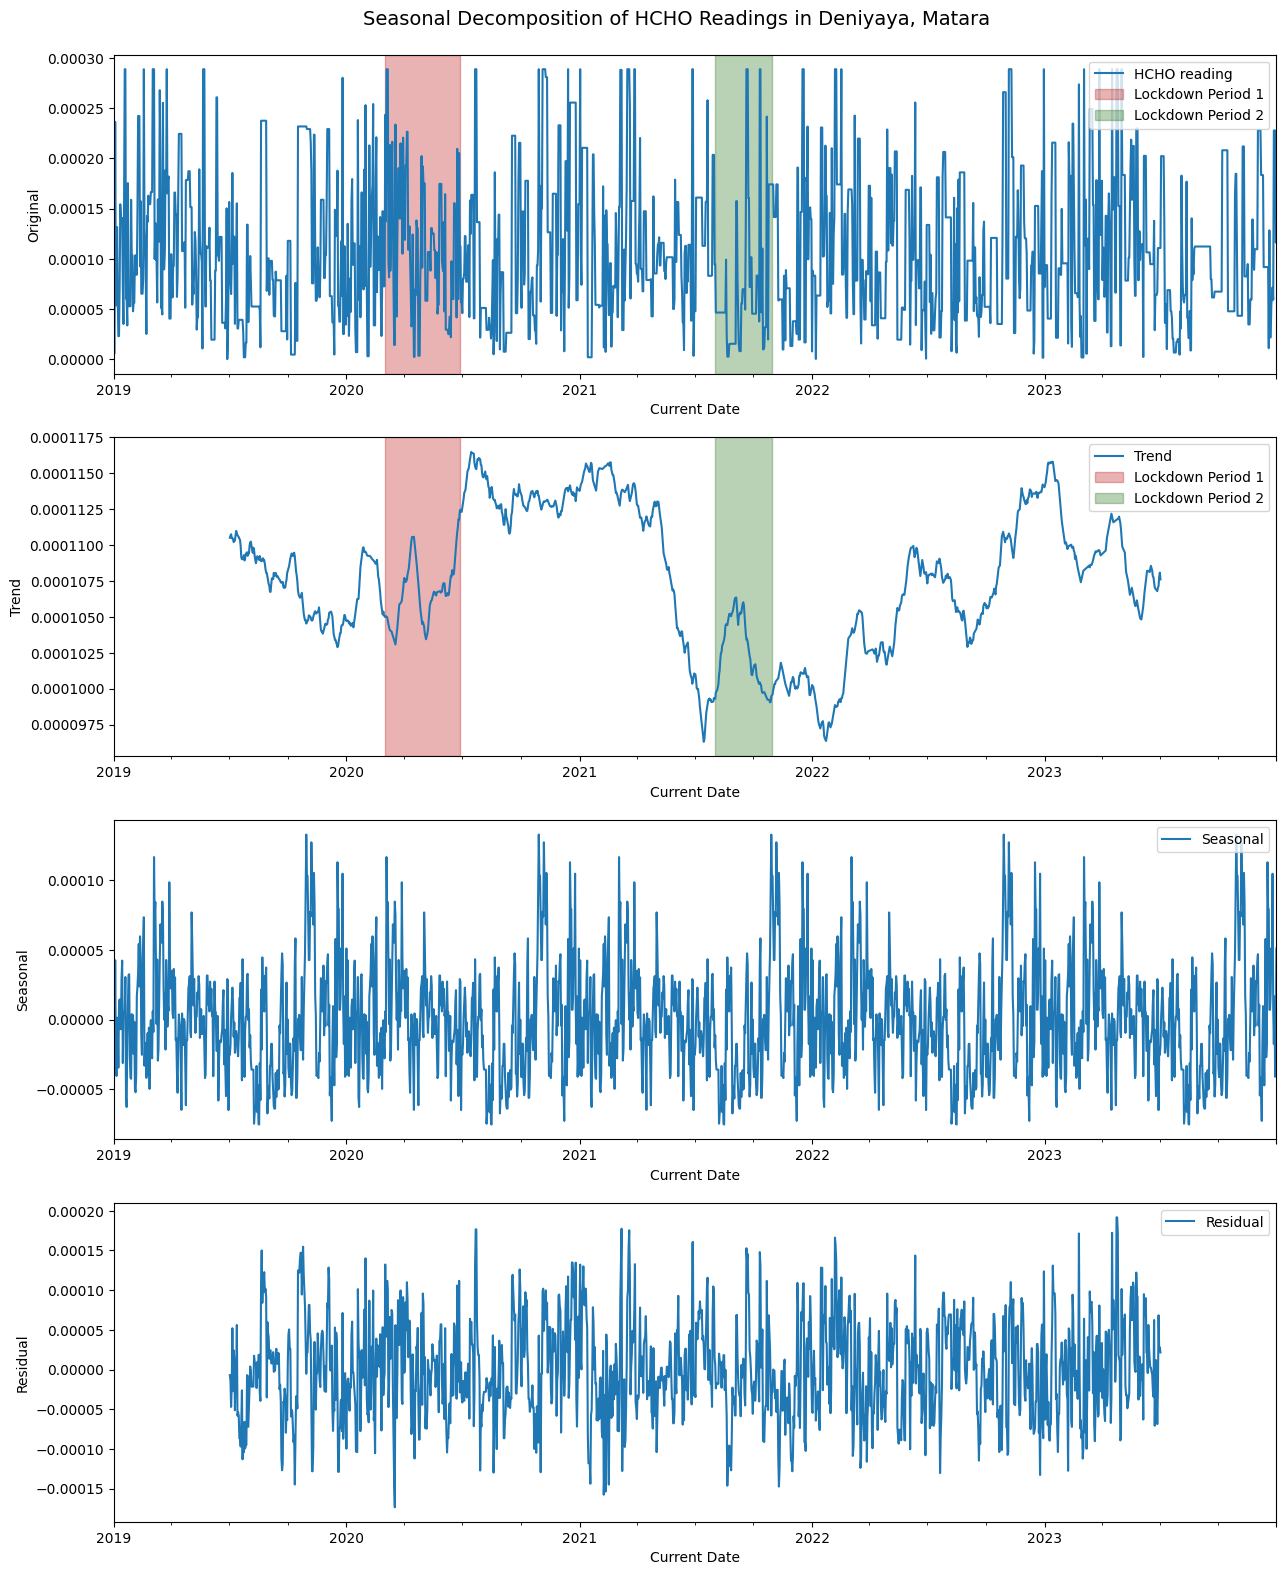

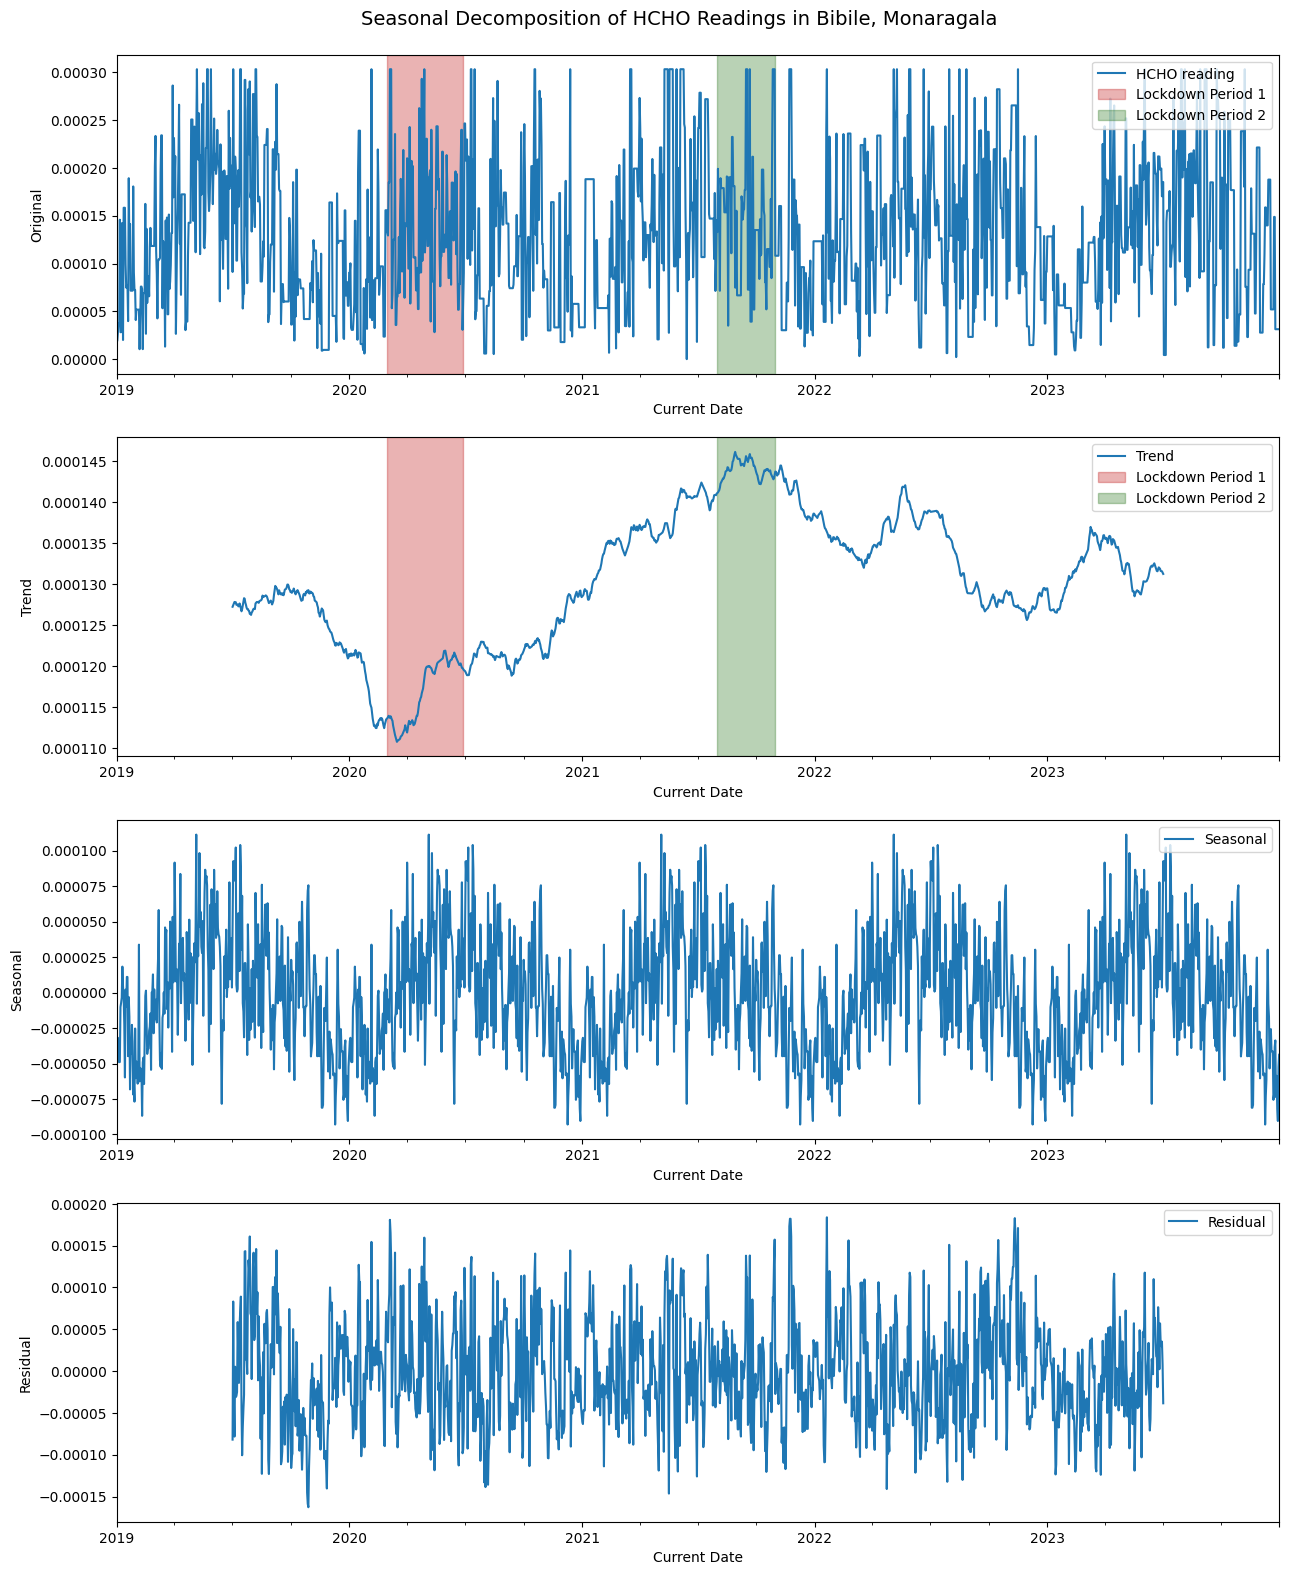

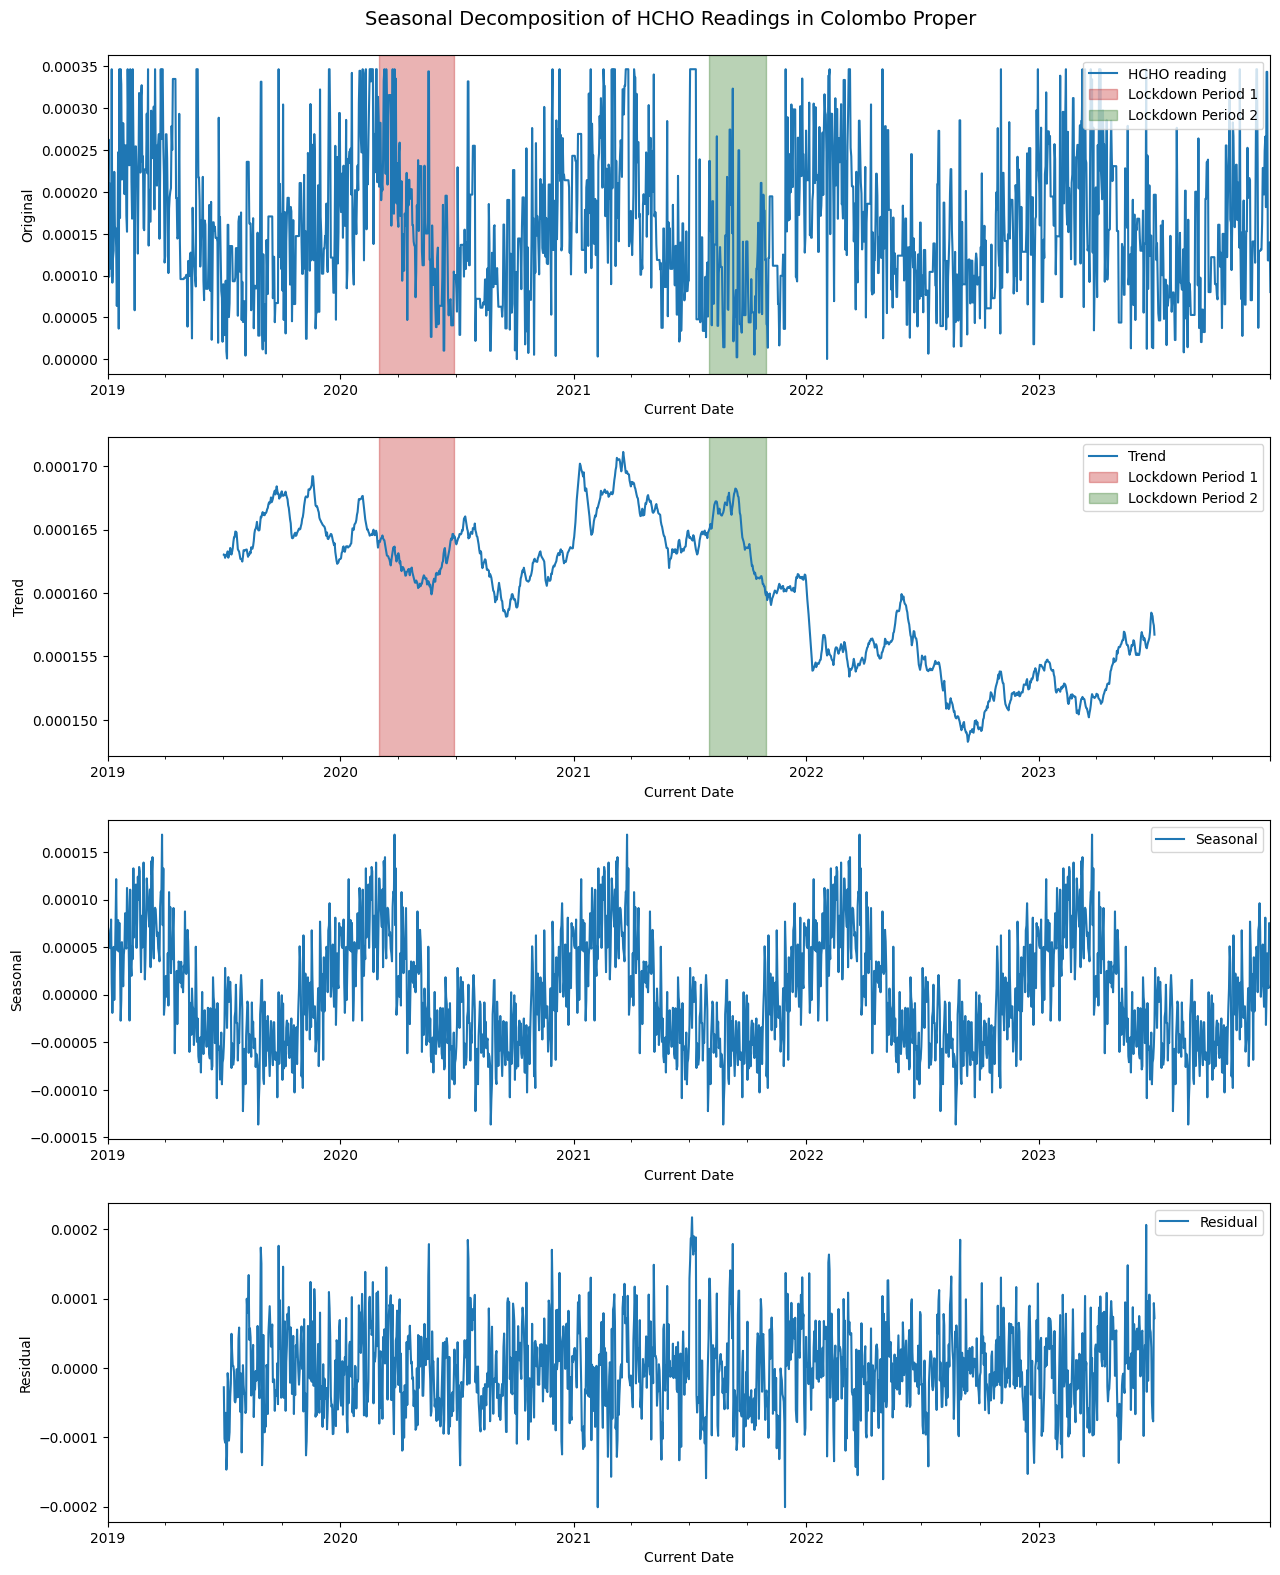

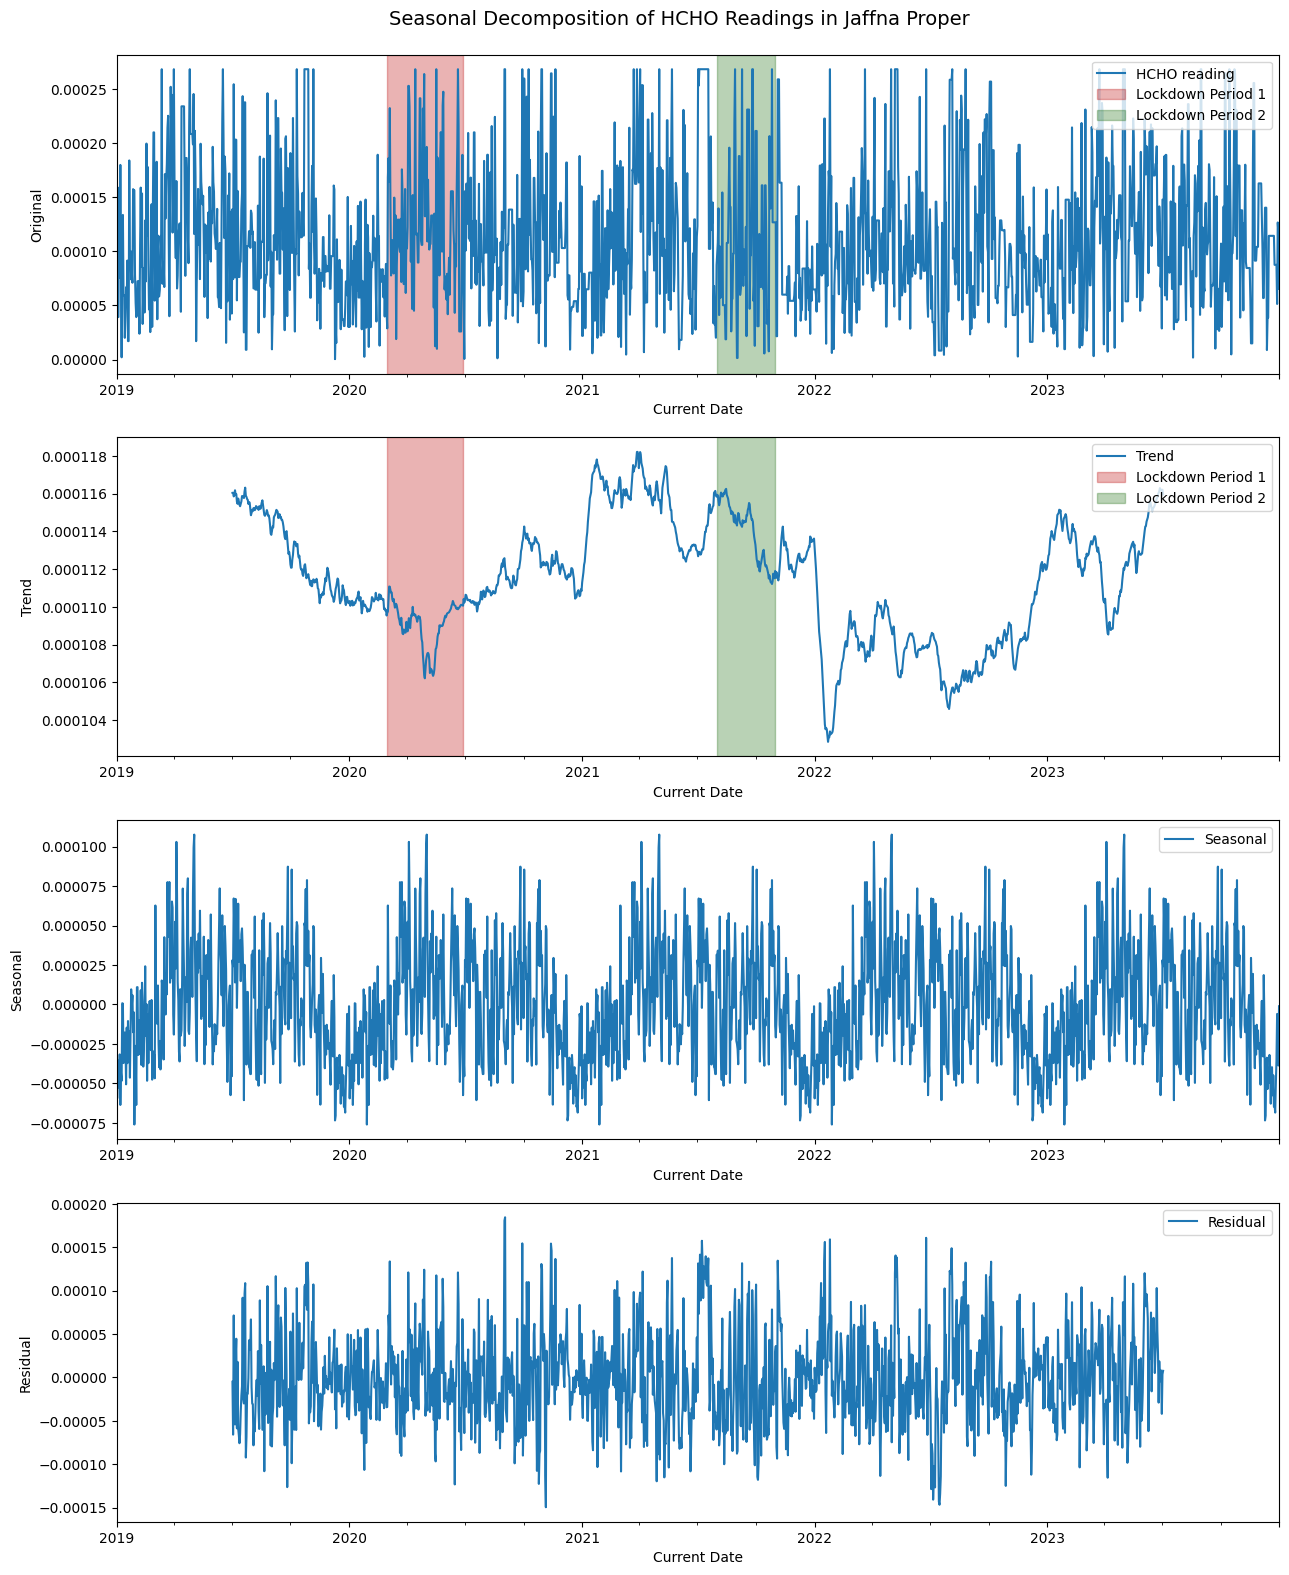

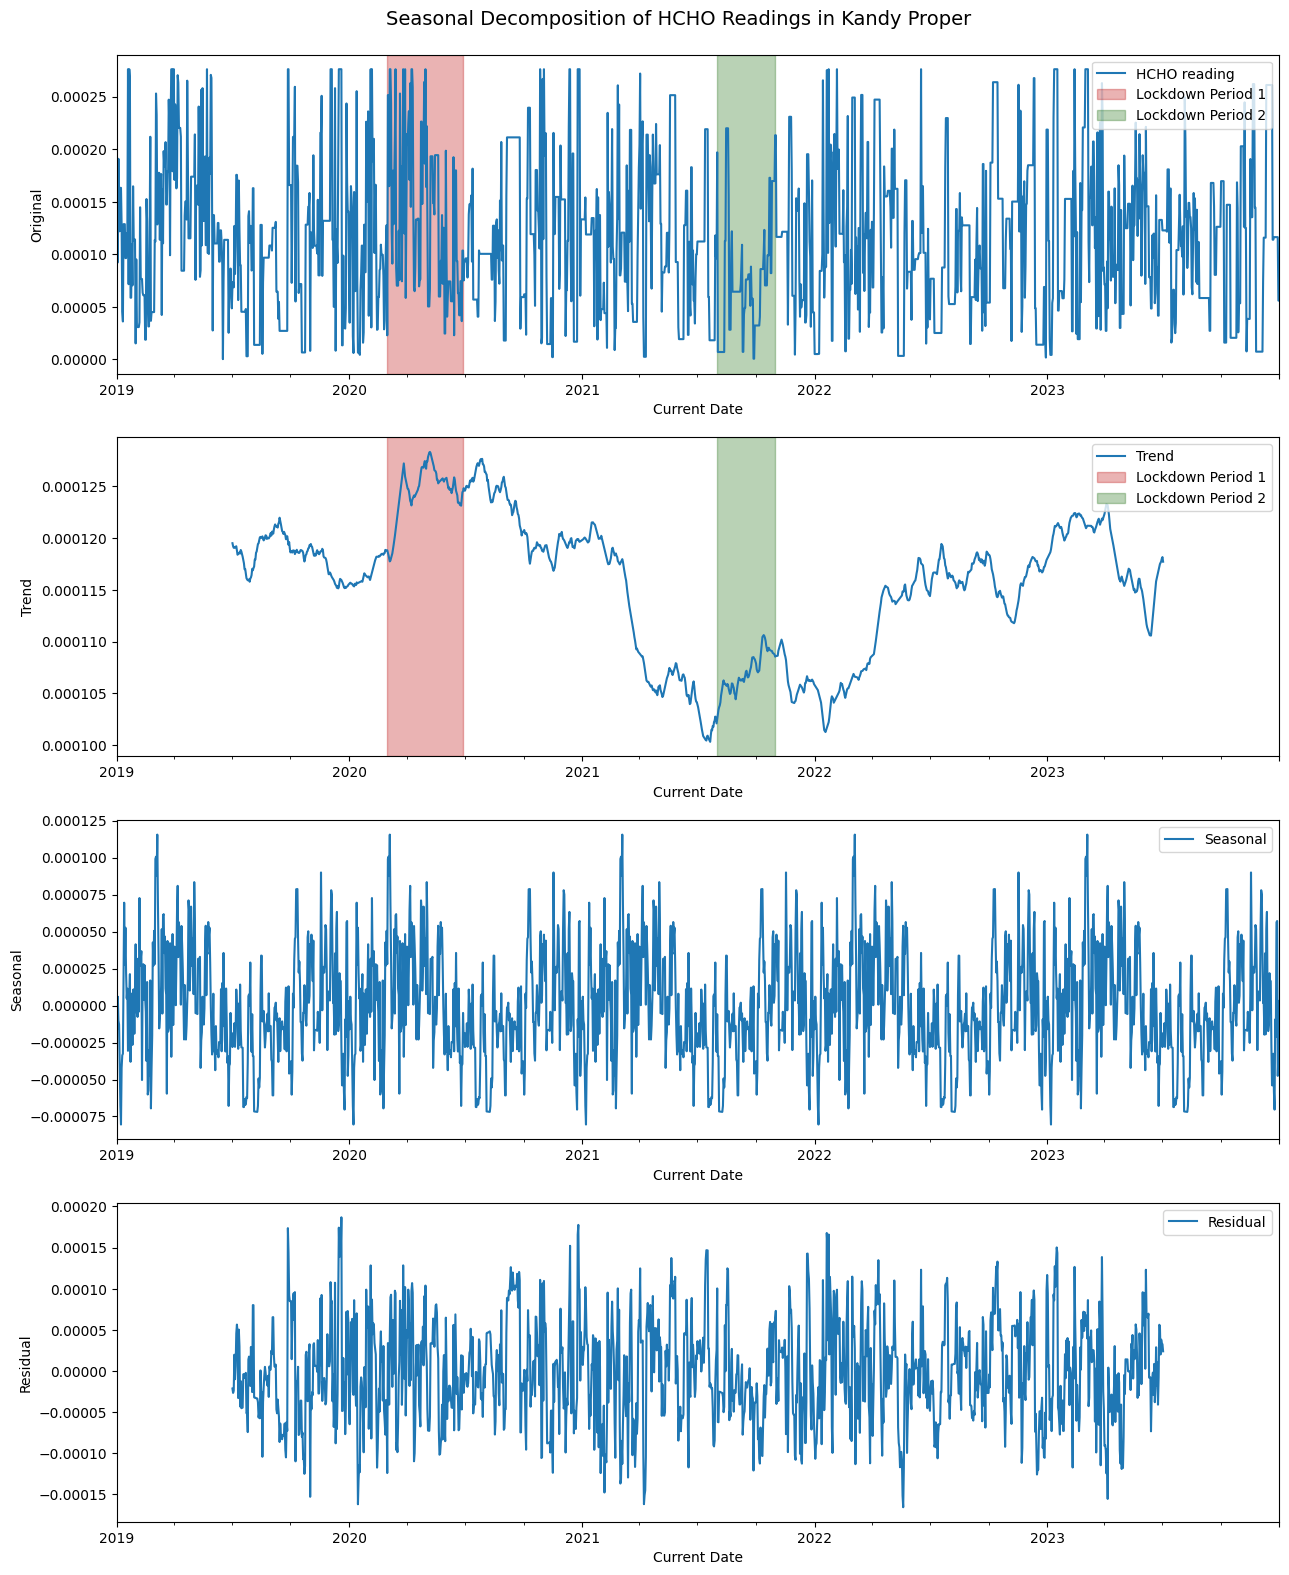

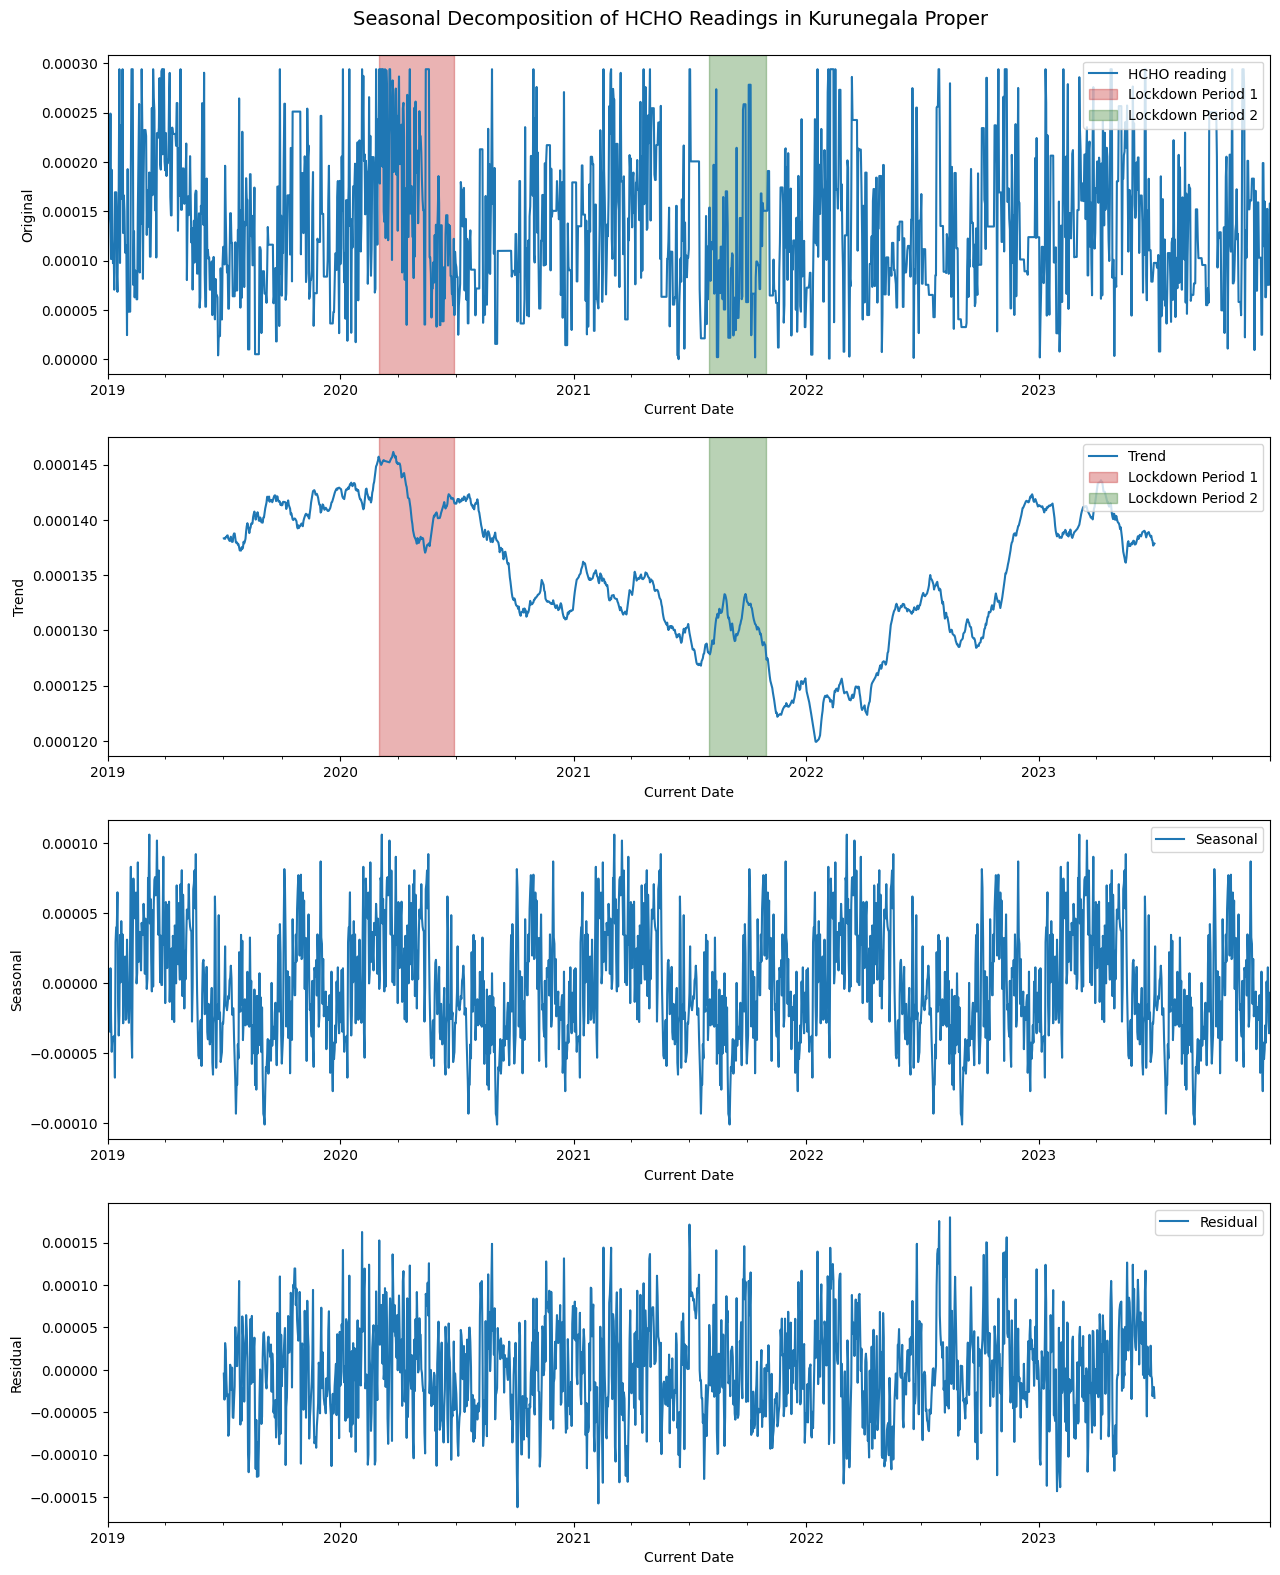

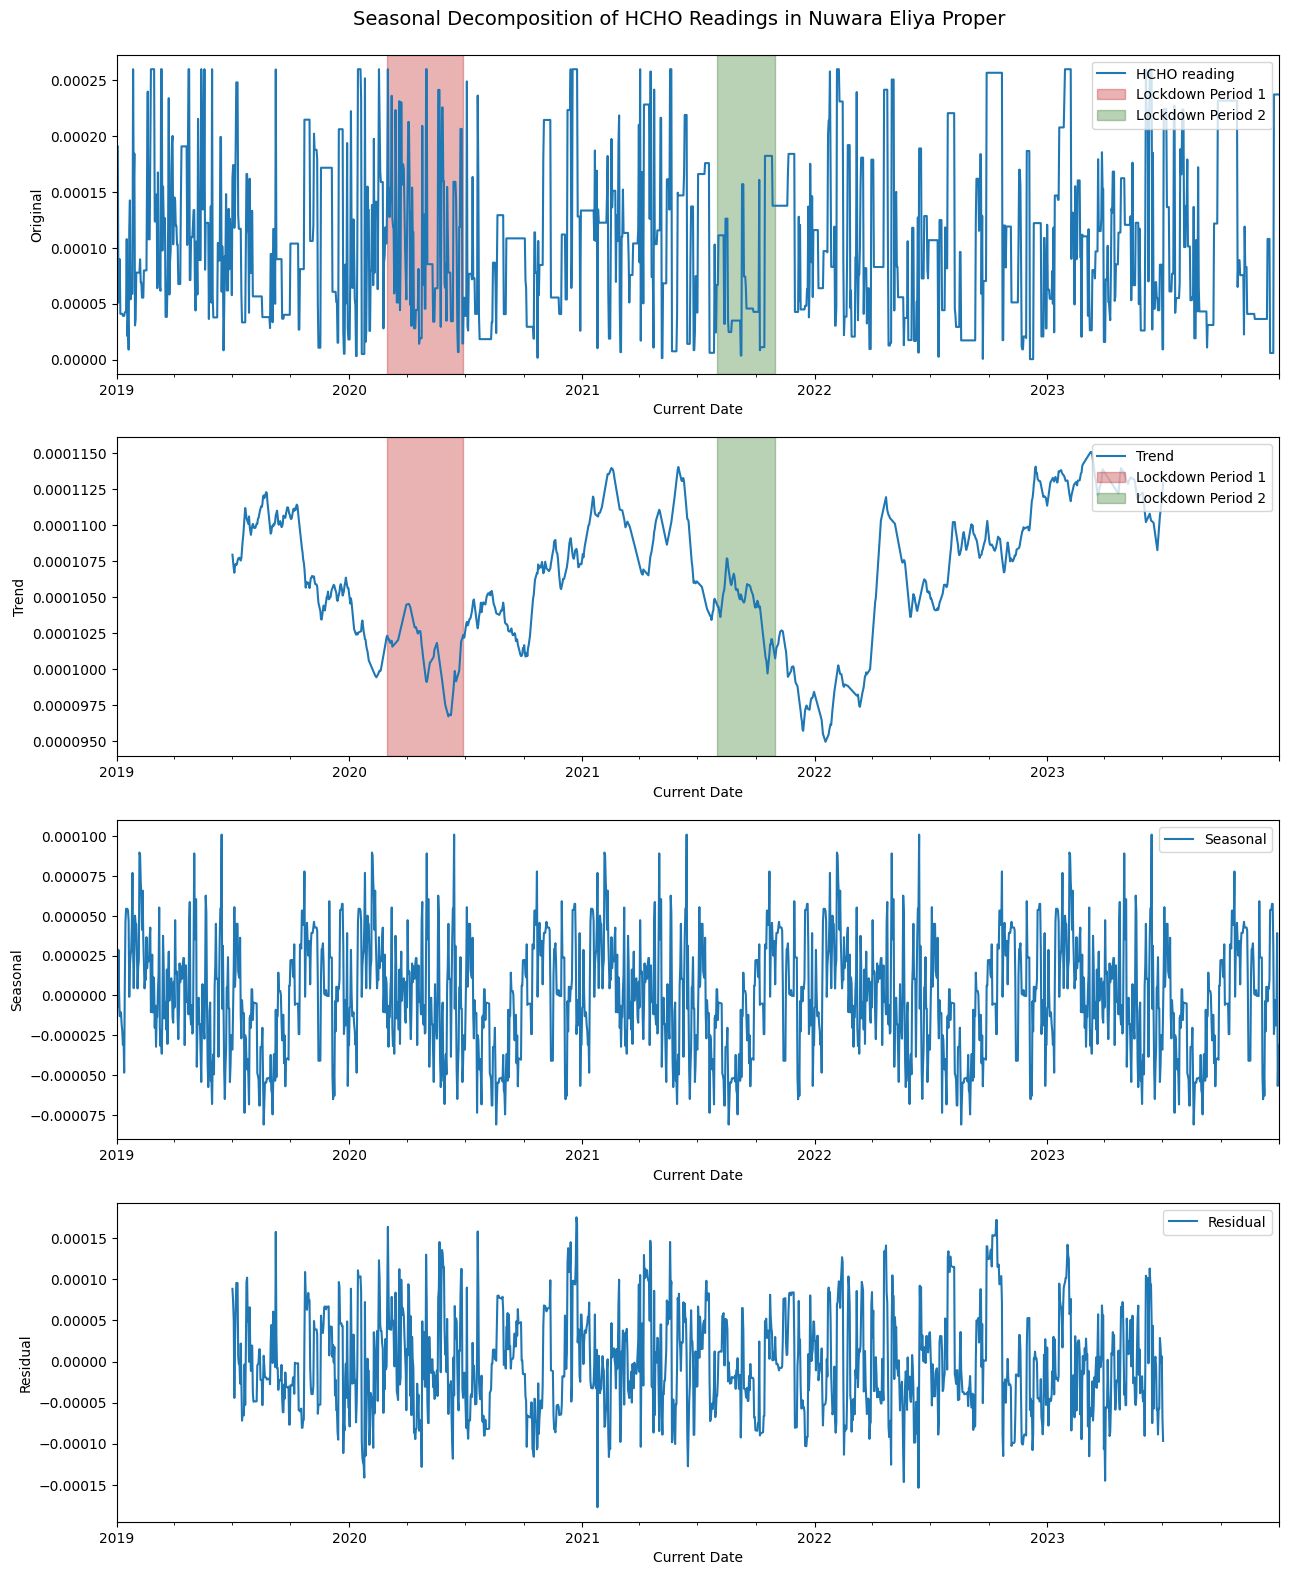

In [7]:
# Load the data
df = get_seasonal_data()

# List of locations
locations = ["Deniyaya, Matara", "Bibile, Monaragala", "Colombo Proper", "Jaffna Proper", "Kandy Proper", "Kurunegala Proper", "Nuwara Eliya Proper"]

# Plot seasonal decomposition of each location
for location_name in locations:
    location_data = df[df["Location"] == location_name]
    plot_seasonal_decomposition(df, location_name)

## Analyzing Correlation of HCHO levels with external factors

Weather Dataset (Kaggle)

In [8]:
# Load datasets
weather_df = spark.read.csv("Dataset/ExternalFactors/SriLanka_Weather_Dataset.csv", header=True, inferSchema=True)
weather_pd = weather_df.toPandas()

In [9]:
num_rows = weather_df.count()
print("Number of rows in weather dataset:", num_rows)

Number of rows in weather dataset: 147480


In [10]:
weather_df.printSchema()

root
 |-- time: date (nullable = true)
 |-- weathercode: integer (nullable = true)
 |-- temperature_2m_max: double (nullable = true)
 |-- temperature_2m_min: double (nullable = true)
 |-- temperature_2m_mean: double (nullable = true)
 |-- apparent_temperature_max: double (nullable = true)
 |-- apparent_temperature_min: double (nullable = true)
 |-- apparent_temperature_mean: double (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- shortwave_radiation_sum: double (nullable = true)
 |-- precipitation_sum: double (nullable = true)
 |-- rain_sum: double (nullable = true)
 |-- snowfall_sum: double (nullable = true)
 |-- precipitation_hours: double (nullable = true)
 |-- windspeed_10m_max: double (nullable = true)
 |-- windgusts_10m_max: double (nullable = true)
 |-- winddirection_10m_dominant: integer (nullable = true)
 |-- et0_fao_evapotranspiration: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: doub

In [11]:
# Get unique cities
print(weather_pd["city"].unique())


['Colombo' 'Mount Lavinia' 'Kesbewa' 'Moratuwa' 'Maharagama' 'Ratnapura'
 'Kandy' 'Negombo' 'Sri Jayewardenepura Kotte' 'Kalmunai' 'Trincomalee'
 'Galle' 'Jaffna' 'Athurugiriya' 'Weligama' 'Matara' 'Kolonnawa' 'Gampaha'
 'Puttalam' 'Badulla' 'Kalutara' 'Bentota' 'Matale' 'Mannar' 'Pothuhera'
 'Kurunegala' 'Mabole' 'Hatton' 'Hambantota' 'Oruwala']


In [12]:
# Remove unwanted cities
cities_to_keep = ['Colombo', 'Kandy', 'Jaffna', 'Matara', 'Kurunegala']
weather_df = weather_df.filter(weather_df["city"].isin(cities_to_keep))
weather_pd = weather_df.toPandas()
print(weather_pd["city"].unique())

['Colombo' 'Kandy' 'Jaffna' 'Matara' 'Kurunegala']


In [13]:
weather_df.show(5)

+----------+-----------+------------------+------------------+-------------------+------------------------+------------------------+-------------------------+-------------------+-------------------+-----------------------+-----------------+--------+------------+-------------------+-----------------+-----------------+--------------------------+--------------------------+--------+---------+---------+---------+-------+
|      time|weathercode|temperature_2m_max|temperature_2m_min|temperature_2m_mean|apparent_temperature_max|apparent_temperature_min|apparent_temperature_mean|            sunrise|             sunset|shortwave_radiation_sum|precipitation_sum|rain_sum|snowfall_sum|precipitation_hours|windspeed_10m_max|windgusts_10m_max|winddirection_10m_dominant|et0_fao_evapotranspiration|latitude|longitude|elevation|  country|   city|
+----------+-----------+------------------+------------------+-------------------+------------------------+------------------------+-------------------------+--

In [14]:
num_rows = weather_df.count()
print("Number of rows in weather dataset after filtering the cities:", num_rows)

Number of rows in weather dataset after filtering the cities: 24580


In [15]:
# Remove unwanted columns
columns_to_keep = ['time', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum', 'rain_sum','windspeed_10m_max','windgusts_10m_max', 'precipitation_hours','elevation', 'city']
weather_df = weather_df.select([F.col(column) for column in columns_to_keep])
weather_df.show()


+----------+------------------+------------------+-------------------+-----------------+--------+-----------------+-----------------+-------------------+---------+-------+
|      time|temperature_2m_max|temperature_2m_min|temperature_2m_mean|precipitation_sum|rain_sum|windspeed_10m_max|windgusts_10m_max|precipitation_hours|elevation|   city|
+----------+------------------+------------------+-------------------+-----------------+--------+-----------------+-----------------+-------------------+---------+-------+
|2010-01-01|              30.0|              22.7|               26.1|              0.0|     0.0|             11.7|             27.4|                0.0|     16.0|Colombo|
|2010-01-02|              29.9|              23.5|               26.2|              0.1|     0.1|             13.0|             27.0|                1.0|     16.0|Colombo|
|2010-01-03|              29.5|              23.2|               26.0|              0.6|     0.6|             12.3|             27.4|       

In [16]:
# Rename column names
weather_df = weather_df.toDF("time","temperature_2m_max","temperature_2m_min","temperature_2m_mean","precipitation_sum","rain_sum","windspeed_10m_max","windgusts_10m_max","precipitation_hours","elevation","city").withColumnRenamed("time", "Date").withColumnRenamed("temperature_2m_max", "Temperature Max").withColumnRenamed("temperature_2m_min", "Temperature Min").withColumnRenamed("temperature_2m_mean", "Temperature Average").withColumnRenamed("precipitation_sum", "Precipitation Sum").withColumnRenamed("rain_sum", "Rain Sum").withColumnRenamed("windspeed_10m_max", "Wind Speed").withColumnRenamed("windgusts_10m_max", "Wind Gust").withColumnRenamed("precipitation_hours", "Precipitation Hours").withColumnRenamed("elevation", "Elevation").withColumnRenamed("city", "Location")

# Show DataFrame with renamed columns
weather_df.show(5)

+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+--------+
|      Date|Temperature Max|Temperature Min|Temperature Average|Precipitation Sum|Rain Sum|Wind Speed|Wind Gust|Precipitation Hours|Elevation|Location|
+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+--------+
|2010-01-01|           30.0|           22.7|               26.1|              0.0|     0.0|      11.7|     27.4|                0.0|     16.0| Colombo|
|2010-01-02|           29.9|           23.5|               26.2|              0.1|     0.1|      13.0|     27.0|                1.0|     16.0| Colombo|
|2010-01-03|           29.5|           23.2|               26.0|              0.6|     0.6|      12.3|     27.4|                3.0|     16.0| Colombo|
|2010-01-04|           28.9|           21.9|               25.3|              0.0|     0

In [17]:
# Rename the 'city' column
weather_df = weather_df.withColumn("Location",
      F.when(F.col("Location") == "Colombo", "Colombo Proper")
     .when(F.col("Location") == "Kandy", "Kandy Proper")
     .when(F.col("Location") == "Jaffna", "Jaffna Proper")
     .when(F.col("Location") == "Matara", "Deniyaya, Matara")
     .when(F.col("Location") == "Kurunegala", "Kurunegala Proper")
     .otherwise(F.col("Location")))

weather_df_pd = weather_df.toPandas()
print(weather_df_pd["Location"].unique())

['Colombo Proper' 'Kandy Proper' 'Jaffna Proper' 'Deniyaya, Matara'
 'Kurunegala Proper']


In [18]:
weather_df.show(5)

+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+--------------+
|      Date|Temperature Max|Temperature Min|Temperature Average|Precipitation Sum|Rain Sum|Wind Speed|Wind Gust|Precipitation Hours|Elevation|      Location|
+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+--------------+
|2010-01-01|           30.0|           22.7|               26.1|              0.0|     0.0|      11.7|     27.4|                0.0|     16.0|Colombo Proper|
|2010-01-02|           29.9|           23.5|               26.2|              0.1|     0.1|      13.0|     27.0|                1.0|     16.0|Colombo Proper|
|2010-01-03|           29.5|           23.2|               26.0|              0.6|     0.6|      12.3|     27.4|                3.0|     16.0|Colombo Proper|
|2010-01-04|           28.9|           21.9|        

In [19]:
print(weather_df_pd["Date"].unique())

[datetime.date(2010, 1, 1) datetime.date(2010, 1, 2)
 datetime.date(2010, 1, 3) ... datetime.date(2023, 6, 15)
 datetime.date(2023, 6, 16) datetime.date(2023, 6, 17)]


In [20]:
# Filter the date range
weather_df = weather_df.filter((F.col("Date") >= "2019-01-01") & (F.col("Date") <= "2023-12-31"))

# Show the filtered DataFrame
weather_df.show()

+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+--------------+
|      Date|Temperature Max|Temperature Min|Temperature Average|Precipitation Sum|Rain Sum|Wind Speed|Wind Gust|Precipitation Hours|Elevation|      Location|
+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+--------------+
|2019-01-01|           30.0|           23.1|               26.1|              0.0|     0.0|      14.4|     29.9|                0.0|     16.0|Colombo Proper|
|2019-01-02|           29.4|           22.7|               25.7|              0.0|     0.0|      16.6|     31.0|                0.0|     16.0|Colombo Proper|
|2019-01-03|           30.2|           22.6|               26.1|              0.0|     0.0|      16.0|     31.0|                0.0|     16.0|Colombo Proper|
|2019-01-04|           30.6|           22.3|        

In [21]:
weather_df_pd = weather_df.toPandas()
print(weather_df_pd["Date"].unique())

[datetime.date(2019, 1, 1) datetime.date(2019, 1, 2)
 datetime.date(2019, 1, 3) ... datetime.date(2023, 6, 15)
 datetime.date(2023, 6, 16) datetime.date(2023, 6, 17)]


In [22]:
# Null value count
null_value_count = weather_df.select([F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias(column) for column in weather_df.columns])

null_value_count.show()

+----+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+--------+
|Date|Temperature Max|Temperature Min|Temperature Average|Precipitation Sum|Rain Sum|Wind Speed|Wind Gust|Precipitation Hours|Elevation|Location|
+----+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+--------+
|   0|              0|              0|                  0|                0|       0|         0|        0|                  0|        0|       0|
+----+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+--------+



In [23]:
# Count the duplicate rows
duplicate_count = weather_df.groupBy(weather_df.columns).count().where(F.col("count") > 1).count()

# Show the count of duplicate rows
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


In [24]:
num_rows = weather_df.count()
print("Number of weather filtered dataset:", num_rows)

Number of weather filtered dataset: 8145


In [25]:
# Save weather_pd as a CSV file
weather_pd = weather_df.toPandas()
weather_pd.to_csv('Dataset/Preprocessed/weather_cleaned.csv', index=False)

### Joining External Factors

In [26]:
# Load datasets
df_join = spark.read.csv("Dataset/Preprocessed/cleaned_data.csv", header=True, inferSchema=True)
weather_join = spark.read.csv("Dataset/Preprocessed/weather_cleaned.csv", header=True, inferSchema=True)

In [27]:
# Filter the locations in cleaned_data
cities_to_keep = ['Colombo Proper', 'Kandy Proper', 'Jaffna Proper', 'Deniyaya, Matara', 'Kurunegala Proper']
cleaned_data_filtered = df_join.filter(df_join["Location"].isin(cities_to_keep))

# Join cleaned_data and weather_df on Location and Date columns
merged_df = cleaned_data_filtered.join(weather_join, (cleaned_data_filtered["Location"] == weather_join["Location"]) & (cleaned_data_filtered["Current Date"] == weather_join["Date"]), how='inner').drop(weather_join["Location"], weather_join["Date"])

# Show the merged DataFrame
merged_df.show()


+--------------------+----------------+------------+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+
|        HCHO reading|        Location|Current Date| Next Date|Temperature Max|Temperature Min|Temperature Average|Precipitation Sum|Rain Sum|Wind Speed|Wind Gust|Precipitation Hours|Elevation|
+--------------------+----------------+------------+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+
|9.462768069002881E-5|Deniyaya, Matara|  2023-06-17|2023-06-18|           28.7|           26.1|               27.1|              6.2|     6.2|      26.1|     47.9|               24.0|      7.0|
|9.462768069002881E-5|Deniyaya, Matara|  2023-06-16|2023-06-17|           29.1|           26.5|               27.6|              3.0|     3.0|      27.1|     50.0|               20.0|      7.0|
|1.063946303141357...|Deniyaya

In [28]:
# Assuming cleaned_data and weather_df are your DataFrames
joined_df = df_join.join(
     weather_join,
     (df_join["Location"] == weather_join["Location"]) &
     (df_join["Current Date"] == weather_join["Date"]),
     how="inner"
 )

# Drop duplicate 'city' column
joined_df = joined_df.drop(weather_df["Location"],weather_df["Date"])

# Show the joined DataFrame
joined_df.show()

+--------------------+----------------+------------+----------+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+----------------+
|        HCHO reading|        Location|Current Date| Next Date|      Date|Temperature Max|Temperature Min|Temperature Average|Precipitation Sum|Rain Sum|Wind Speed|Wind Gust|Precipitation Hours|Elevation|        Location|
+--------------------+----------------+------------+----------+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+----------------+
|9.462768069002881E-5|Deniyaya, Matara|  2023-06-17|2023-06-18|2023-06-17|           28.7|           26.1|               27.1|              6.2|     6.2|      26.1|     47.9|               24.0|      7.0|Deniyaya, Matara|
|9.462768069002881E-5|Deniyaya, Matara|  2023-06-16|2023-06-17|2023-06-16|           29.1|           26.5|      

In [29]:
# Null value count
null_value_count = merged_df.select([F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias(column) for column in merged_df.columns])

null_value_count.show()

+------------+--------+------------+---------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+
|HCHO reading|Location|Current Date|Next Date|Temperature Max|Temperature Min|Temperature Average|Precipitation Sum|Rain Sum|Wind Speed|Wind Gust|Precipitation Hours|Elevation|
+------------+--------+------------+---------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+
|           0|       0|           0|        0|              0|              0|                  0|                0|       0|         0|        0|                  0|        0|
+------------+--------+------------+---------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+



In [30]:
# Display the data count of each location
location_count = merged_df.groupBy("Location").count().orderBy("Location")
location_count.show()

+-----------------+-----+
|         Location|count|
+-----------------+-----+
|   Colombo Proper| 1629|
| Deniyaya, Matara| 1629|
|    Jaffna Proper| 1629|
|     Kandy Proper| 1629|
|Kurunegala Proper| 1629|
+-----------------+-----+



In [31]:
num_rows = weather_join.count()
print("Number of rows in full dataset:", num_rows)

Number of rows in full dataset: 8145


In [32]:
# Save merged_df as a CSV file
merged_pd = merged_df.toPandas()
merged_pd.to_csv('Dataset/Preprocessed/merged_dataset_with_external_factors.csv', index=False)

### Analyzing Dataset with External Factors

In [33]:
merged_data = spark.read.csv("Dataset/Preprocessed/merged_dataset_with_external_factors.csv", header=True, inferSchema=True)
merged_df.show()

+--------------------+----------------+------------+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+
|        HCHO reading|        Location|Current Date| Next Date|Temperature Max|Temperature Min|Temperature Average|Precipitation Sum|Rain Sum|Wind Speed|Wind Gust|Precipitation Hours|Elevation|
+--------------------+----------------+------------+----------+---------------+---------------+-------------------+-----------------+--------+----------+---------+-------------------+---------+
|9.462768069002881E-5|Deniyaya, Matara|  2023-06-17|2023-06-18|           28.7|           26.1|               27.1|              6.2|     6.2|      26.1|     47.9|               24.0|      7.0|
|9.462768069002881E-5|Deniyaya, Matara|  2023-06-16|2023-06-17|           29.1|           26.5|               27.6|              3.0|     3.0|      27.1|     50.0|               20.0|      7.0|
|1.063946303141357...|Deniyaya

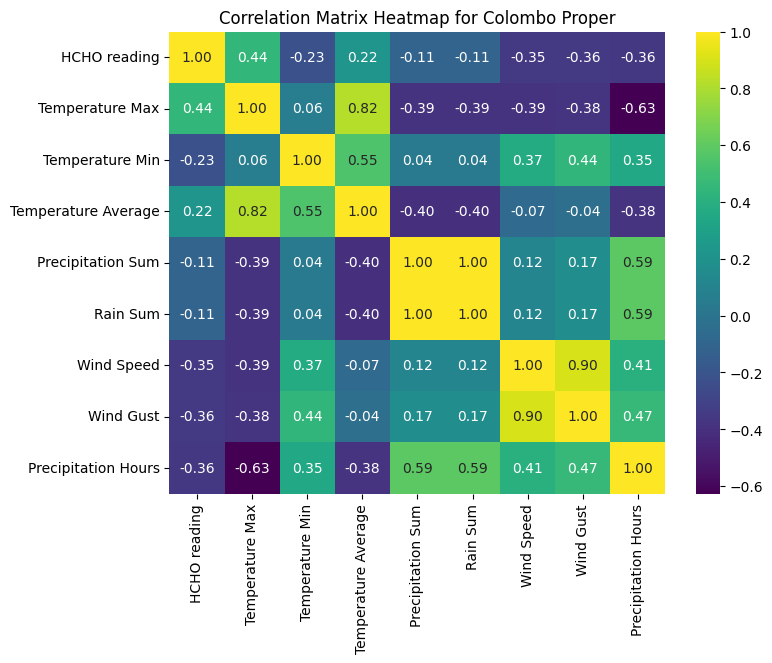

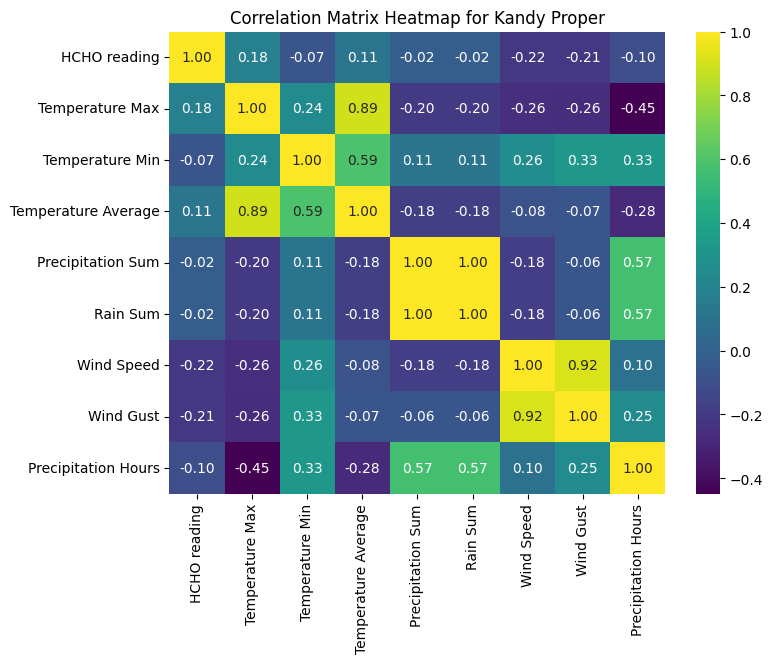

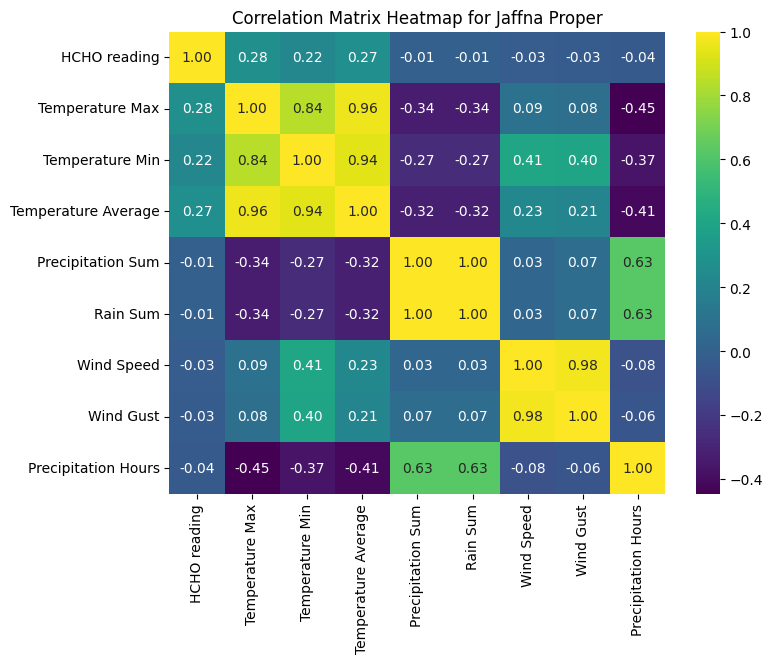

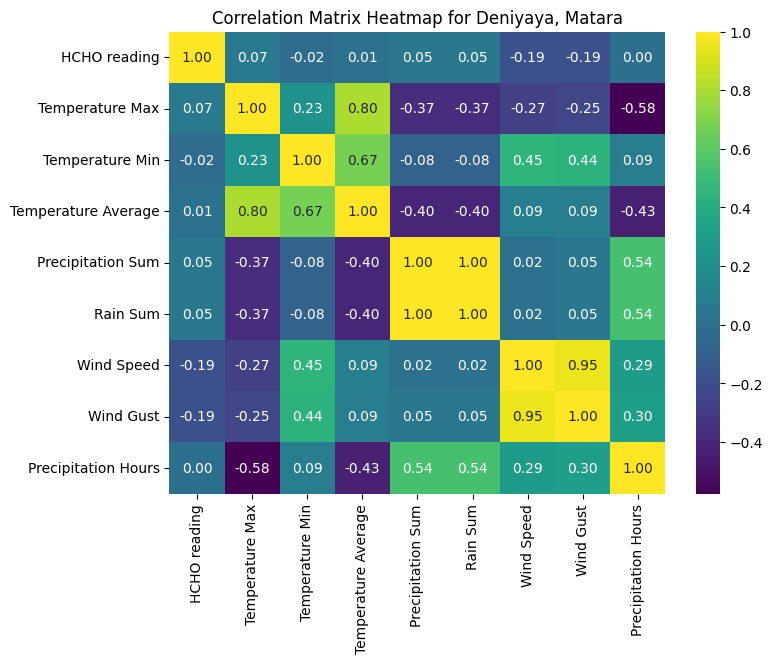

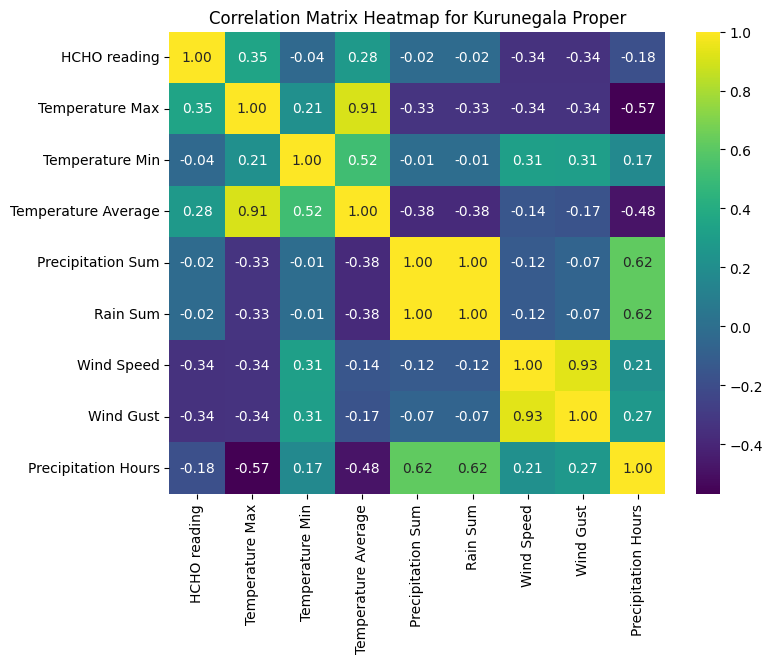

In [34]:
# List of locations
locations = ["Colombo Proper", "Kandy Proper", "Jaffna Proper", "Deniyaya, Matara", "Kurunegala Proper"]

# Loop through each location
for location_name in locations:
    # Filter the data for the current location
    location_data = merged_data[merged_data["Location"] == location_name]

    # Select columns for correlation
    cols_for_corr = ['HCHO reading','Temperature Max','Temperature Min','Temperature Average','Precipitation Sum','Rain Sum','Wind Speed','Wind Gust','Precipitation Hours']
    corr_data = location_data[cols_for_corr]

    # Calculate the correlation matrix
    correlation_matrix = corr_data.toPandas().corr()

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
    plt.title(f"Correlation Matrix Heatmap for {location_name}")
    plt.show()
    print("\n")


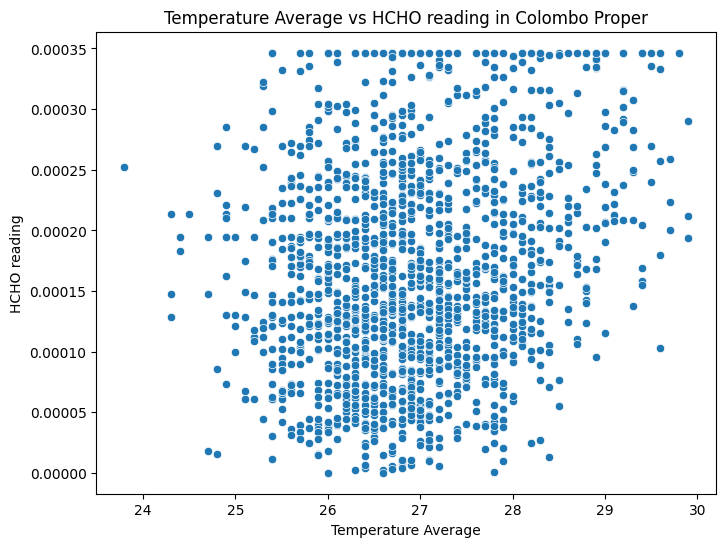

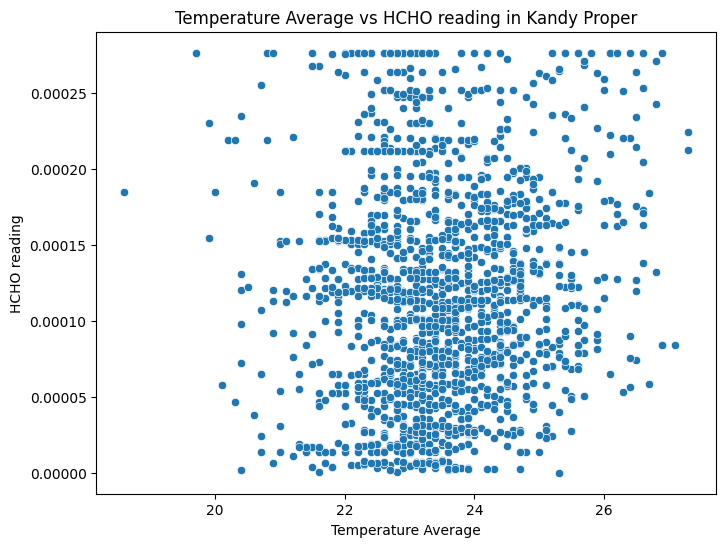

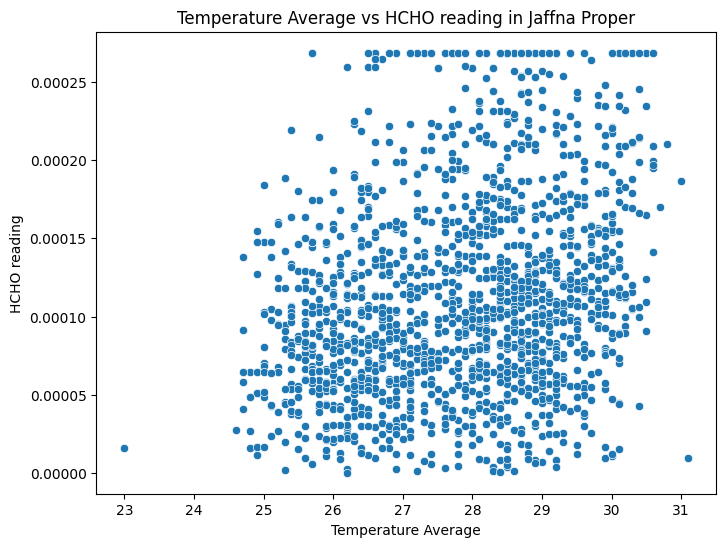

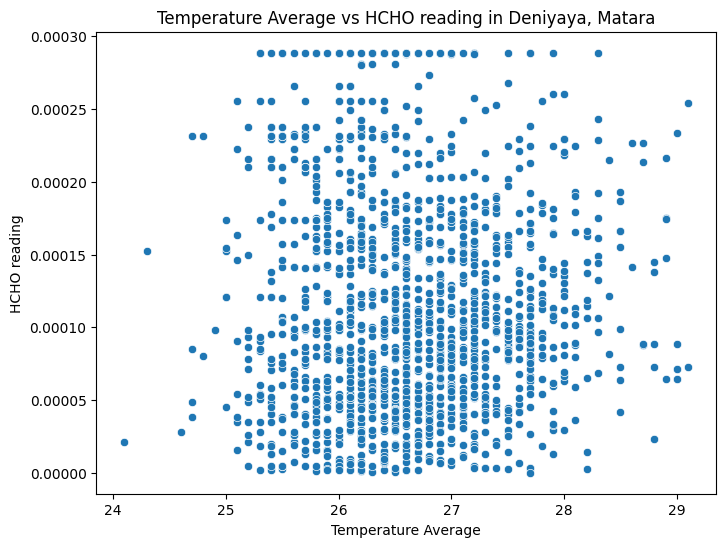

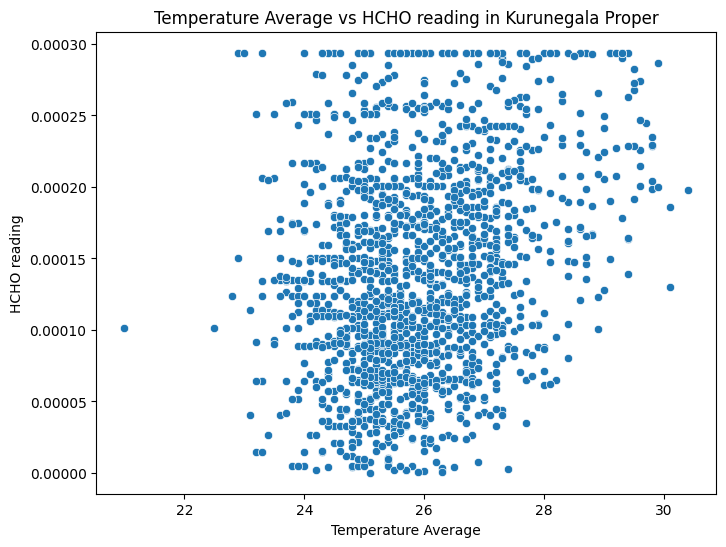

In [35]:
# Plot the scatter plot
for location_name in locations:
    # Filter the data for the current location
    location_data = merged_data[merged_data["Location"] == location_name]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="Temperature Average", y="HCHO reading", data=location_data.toPandas())
    plt.title(f"Temperature Average vs HCHO reading in {location_name}")
    plt.xlabel("Temperature Average")
    plt.ylabel("HCHO reading")
    plt.show()
    print("\n")

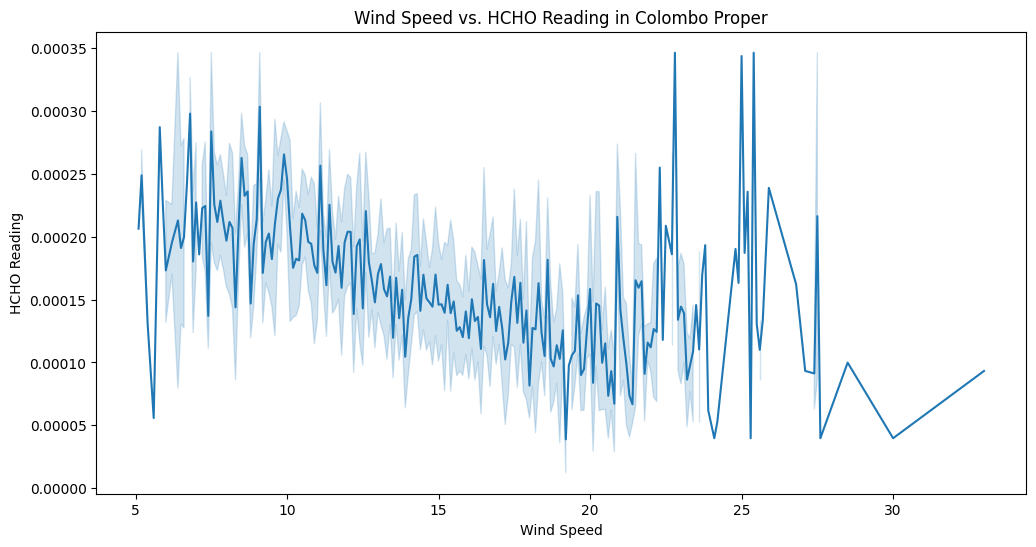

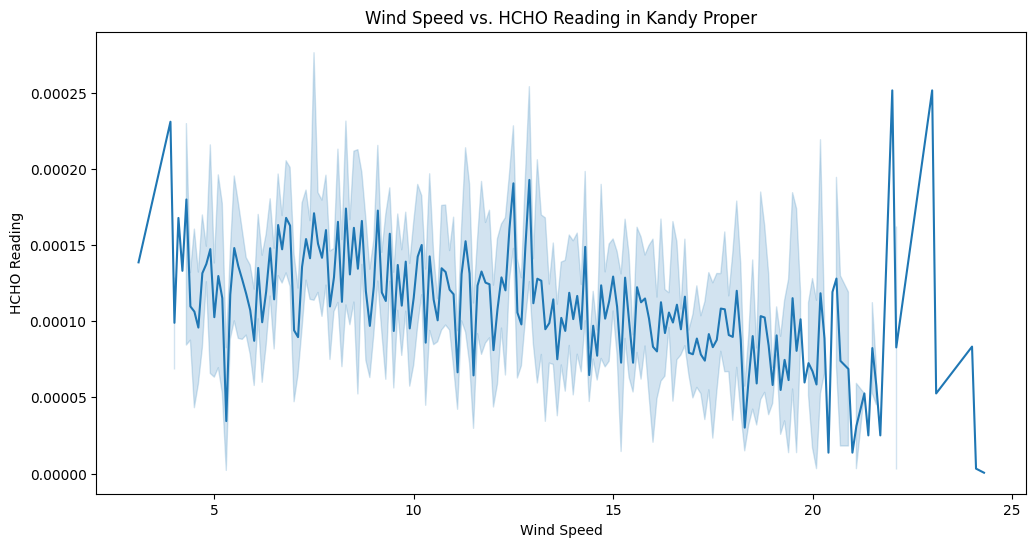

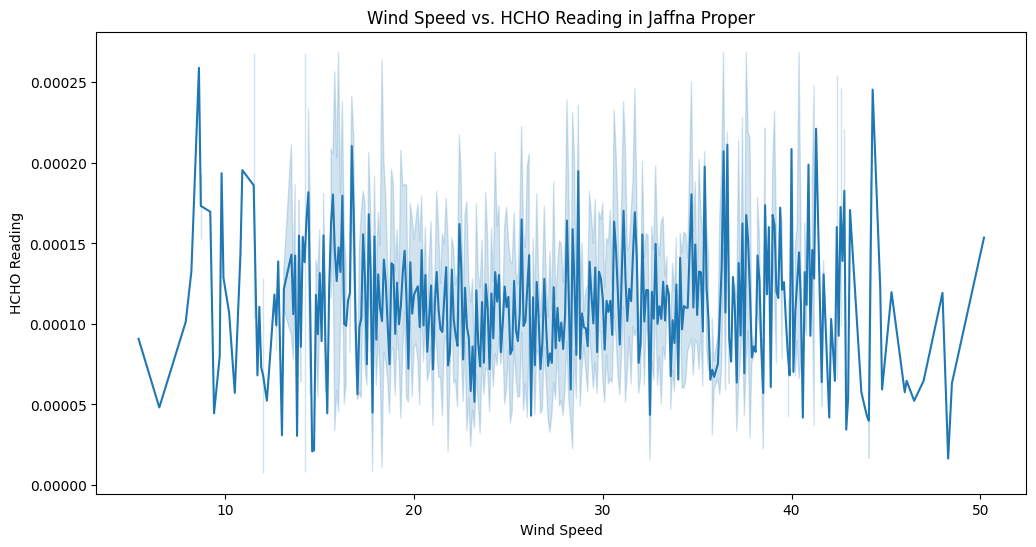

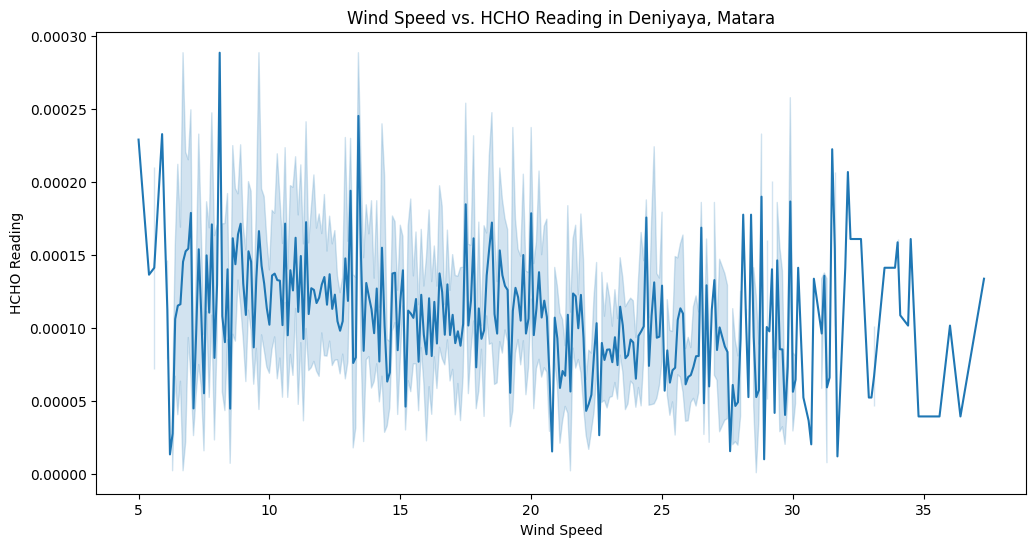

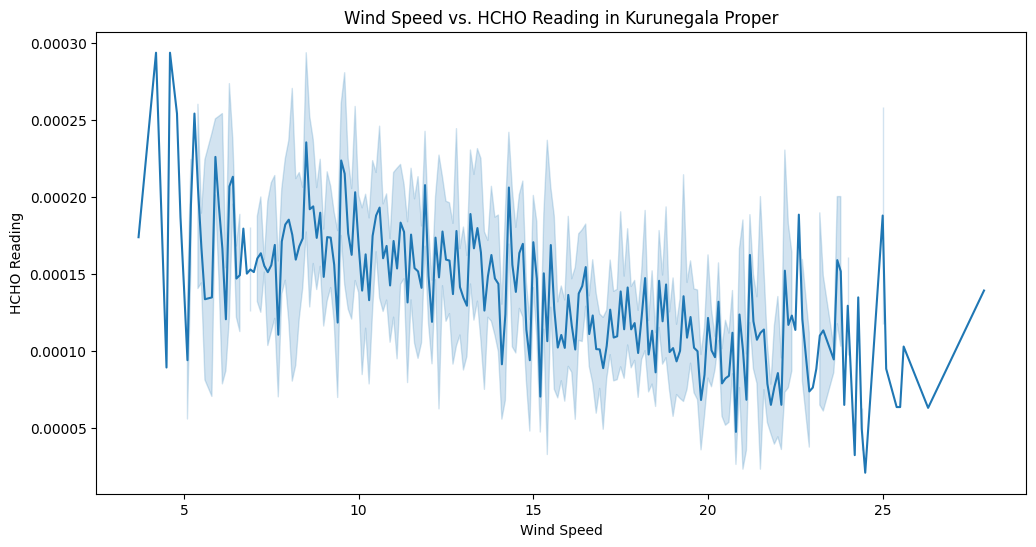

In [36]:
for location_name in locations:
    # Filter the data for the current location
    location_data = merged_data[merged_data["Location"] == location_name]
    # Plot the line plot

    plt.figure(figsize=(12, 6))
    sns.lineplot(x="Wind Speed", y="HCHO reading", data=location_data.toPandas())
    plt.title(f"Wind Speed vs. HCHO Reading in {location_name}")
    plt.xlabel("Wind Speed")
    plt.ylabel("HCHO Reading")
    plt.show()
    print("\n")

## Comparing Spatial Patterns

Population Dataset (Department of Census and Statistics)

In [37]:
population_df = spark.read.csv("Dataset/ExternalFactors/Population.csv", header=True, inferSchema=True)
population_df.show()

+------------+--------+----+
|    District|  Total |Year|
+------------+--------+----+
|   Sri Lanka|21803000|2019|
|     Colombo| 2448000|2019|
|     Gampaha| 2417000|2019|
|    Kalutara| 1284000|2019|
|       Kandy| 1476000|2019|
|      Matale|  522000|2019|
|Nuwara-eliya|  768000|2019|
|       Galle| 1130000|2019|
|      Matara|  863000|2019|
|  Hambantota|  661000|2019|
|      Jaffna|  617000|2019|
| Kilinochchi|  129000|2019|
|      Mannar|  111000|2019|
|    Vavuniya|  189000|2019|
|  Mullaitivu|   97000|2019|
|  Batticaloa|  575000|2019|
|      Ampara|  728000|2019|
| Trincomalee|  426000|2019|
|  Kurunegala| 1719000|2019|
|    Puttalam|  832000|2019|
+------------+--------+----+
only showing top 20 rows



In [38]:
population_df.printSchema()

root
 |-- District: string (nullable = true)
 |--  Total : integer (nullable = true)
 |-- Year: integer (nullable = true)



In [39]:
# Get unique years
population_pd = population_df.toPandas()
print(population_pd["Year"].unique())

[2019 2020 2021 2022 2023]


In [40]:
# Get unique cities
print(population_pd["District"].unique())

['Sri Lanka' 'Colombo' 'Gampaha' 'Kalutara' 'Kandy' 'Matale'
 'Nuwara-eliya' 'Galle' 'Matara' 'Hambantota' 'Jaffna' 'Kilinochchi'
 'Mannar' 'Vavuniya' 'Mullaitivu' 'Batticaloa' 'Ampara' 'Trincomalee'
 'Kurunegala' 'Puttalam' 'Anuradhapura' 'Polonnaruwa' 'Badulla'
 'Monaragala' 'Ratnapura' 'Kegalle']


In [41]:
# Null value count
null_value_count = population_df.select([F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias(column) for column in population_df.columns])

null_value_count.show()

+--------+-------+----+
|District| Total |Year|
+--------+-------+----+
|       0|      0|   0|
+--------+-------+----+



In [42]:
# Count the duplicate rows
duplicate_count = population_df.groupBy(population_df.columns).count().where(F.col("count") > 1).count()

# Show the count of duplicate rows
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


In [43]:
# Remove unwanted cities
cities_to_keep = ['Colombo', 'Kandy', 'Jaffna', 'Matara', 'Kurunegala','Nuwara-eliya','Monaragala']
population_df = population_df.filter(population_df["District"].isin(cities_to_keep))
population_pd = population_df.toPandas()
print(population_pd["District"].unique())

['Colombo' 'Kandy' 'Nuwara-eliya' 'Matara' 'Jaffna' 'Kurunegala'
 'Monaragala']


In [44]:
population_df.show()

+------------+-------+----+
|    District| Total |Year|
+------------+-------+----+
|     Colombo|2448000|2019|
|       Kandy|1476000|2019|
|Nuwara-eliya| 768000|2019|
|      Matara| 863000|2019|
|      Jaffna| 617000|2019|
|  Kurunegala|1719000|2019|
|  Monaragala| 496000|2019|
|     Colombo|2455000|2020|
|       Kandy|1483000|2020|
|Nuwara-eliya| 773000|2020|
|      Matara| 866000|2020|
|      Jaffna| 621000|2020|
|  Kurunegala|1726000|2020|
|  Monaragala| 501000|2020|
|     Colombo|2480000|2021|
|       Kandy|1501000|2021|
|Nuwara-eliya| 780000|2021|
|      Matara| 873000|2021|
|      Jaffna| 626000|2021|
|  Kurunegala|1743000|2021|
+------------+-------+----+
only showing top 20 rows



In [45]:
# Rename the 'District' column
population_df = population_df.withColumn("District",
      F.when(F.col("District") == "Colombo", "Colombo Proper")
     .when(F.col("District") == "Kandy", "Kandy Proper")
     .when(F.col("District") == "Jaffna", "Jaffna Proper")
     .when(F.col("District") == "Matara", "Deniyaya, Matara")
     .when(F.col("District") == "Kurunegala", "Kurunegala Proper")
     .when(F.col("District") == "Nuwara-eliya", "Nuwara Eliya Proper")
     .when(F.col("District") == "Monaragala", "Bibile, Monaragala")
     .otherwise(F.col("District")))

population_pd = population_df.toPandas()
print(population_pd["District"].unique())

['Colombo Proper' 'Kandy Proper' 'Nuwara Eliya Proper' 'Deniyaya, Matara'
 'Jaffna Proper' 'Kurunegala Proper' 'Bibile, Monaragala']


In [46]:
# Rename column names
population_df = population_df.toDF("District","Total","Year").withColumnRenamed("Total", "Total Population")

In [47]:
population_df.show(7)

+-------------------+----------------+----+
|           District|Total Population|Year|
+-------------------+----------------+----+
|     Colombo Proper|         2448000|2019|
|       Kandy Proper|         1476000|2019|
|Nuwara Eliya Proper|          768000|2019|
|   Deniyaya, Matara|          863000|2019|
|      Jaffna Proper|          617000|2019|
|  Kurunegala Proper|         1719000|2019|
| Bibile, Monaragala|          496000|2019|
+-------------------+----------------+----+
only showing top 7 rows



Area Dataset (Department of Census and Statistics)

In [48]:
area_df = spark.read.csv("Dataset/ExternalFactors/Area.csv", header=True, inferSchema=True)
area_df.show()

+-----------------+------+------+-------------+
|         District| Total|  Land|Inland waters|
+-----------------+------+------+-------------+
|        Sri Lanka|65,610|62,705|        2,905|
| Western Province| 3,684| 3,593|           91|
|          Colombo|   699|   676|           23|
|          Gampaha| 1,387| 1,341|           46|
|         Kalutara| 1,598| 1,576|           22|
| Central Province| 5,674| 5,575|           99|
|            Kandy| 1,940| 1,917|           23|
|           Matale| 1,993| 1,952|           41|
|     Nuwara Eliya| 1,741| 1,706|           35|
|Southern Province| 5,544| 5,383|          161|
|            Galle| 1,652| 1,617|           35|
|           Matara| 1,283| 1,270|           13|
|       Hambantota| 2,609| 2,496|          113|
|Northern Province| 8,884| 8,290|          594|
|           Jaffna| 1,025|   929|           96|
|           Mannar| 1,996| 1,880|          116|
|         Vavuniya| 1,891| 1,787|          104|
|       Mullaitivu| 2,693| 2,489|       

In [49]:
area_df.printSchema()

root
 |-- District: string (nullable = true)
 |-- Total: string (nullable = true)
 |-- Land: string (nullable = true)
 |-- Inland waters: string (nullable = true)



In [50]:
# Get unique cities
area_pd = area_df.toPandas()
print(area_pd["District"].unique())

['Sri Lanka' 'Western Province' 'Colombo' 'Gampaha' 'Kalutara'
 'Central Province' 'Kandy' 'Matale' 'Nuwara Eliya' 'Southern Province'
 'Galle' 'Matara' 'Hambantota' 'Northern Province' 'Jaffna' 'Mannar'
 'Vavuniya' 'Mullaitivu' 'Kilinochchi' 'Eastern Province' 'Batticaloa'
 'Ampara' 'Trincomalee' 'North-Western Province' 'Kurunegala' 'Puttalam'
 'North Central Province' 'Anuradhapura' 'Polonnaruwa' 'Uva Province'
 'Badulla' 'Moneragala' 'Sabaragamuwa Province' 'Ratnapura' 'Kegalle']


In [51]:
# Null value count
null_value_count = area_df.select([F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias(column) for column in area_df.columns])
null_value_count.show()

+--------+-----+----+-------------+
|District|Total|Land|Inland waters|
+--------+-----+----+-------------+
|       0|    0|   0|            0|
+--------+-----+----+-------------+



In [52]:
# Count the duplicate rows
duplicate_count = area_df.groupBy(area_df.columns).count().where(F.col("count") > 1).count()

# Show the count of duplicate rows
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


In [53]:
# Remove unwanted cities
cities_to_keep = ['Colombo', 'Kandy', 'Jaffna', 'Matara', 'Kurunegala','Nuwara Eliya','Moneragala']
area_df = area_df.filter(area_df["District"].isin(cities_to_keep))
area_pd = area_df.toPandas()
print(area_pd["District"].unique())

['Colombo' 'Kandy' 'Nuwara Eliya' 'Matara' 'Jaffna' 'Kurunegala'
 'Moneragala']


In [54]:
# Rename the 'District' column
area_df = area_df.withColumn("District",
      F.when(F.col("District") == "Colombo", "Colombo Proper")
     .when(F.col("District") == "Kandy", "Kandy Proper")
     .when(F.col("District") == "Jaffna", "Jaffna Proper")
     .when(F.col("District") == "Matara", "Deniyaya, Matara")
     .when(F.col("District") == "Kurunegala", "Kurunegala Proper")
     .when(F.col("District") == "Nuwara Eliya", "Nuwara Eliya Proper")
     .when(F.col("District") == "Moneragala", "Bibile, Monaragala")
     .otherwise(F.col("District")))

area_pd = area_df.toPandas()
print(area_pd["District"].unique())

['Colombo Proper' 'Kandy Proper' 'Nuwara Eliya Proper' 'Deniyaya, Matara'
 'Jaffna Proper' 'Kurunegala Proper' 'Bibile, Monaragala']


In [55]:
area_df.show(7)

+-------------------+-----+-----+-------------+
|           District|Total| Land|Inland waters|
+-------------------+-----+-----+-------------+
|     Colombo Proper|  699|  676|           23|
|       Kandy Proper|1,940|1,917|           23|
|Nuwara Eliya Proper|1,741|1,706|           35|
|   Deniyaya, Matara|1,283|1,270|           13|
|      Jaffna Proper|1,025|  929|           96|
|  Kurunegala Proper|4,816|4,624|          192|
| Bibile, Monaragala|5,639|5,508|          131|
+-------------------+-----+-----+-------------+



In [56]:
# Remove unwanted columns
columns_to_keep = ['District', 'Land']
area_df = area_df.select([F.col(column) for column in columns_to_keep])
area_df.show()

+-------------------+-----+
|           District| Land|
+-------------------+-----+
|     Colombo Proper|  676|
|       Kandy Proper|1,917|
|Nuwara Eliya Proper|1,706|
|   Deniyaya, Matara|1,270|
|      Jaffna Proper|  929|
|  Kurunegala Proper|4,624|
| Bibile, Monaragala|5,508|
+-------------------+-----+



In [57]:
# Rename column names
area_df = area_df.toDF("District","Land").withColumnRenamed("Land", "Land Area")
area_df.show()

+-------------------+---------+
|           District|Land Area|
+-------------------+---------+
|     Colombo Proper|      676|
|       Kandy Proper|    1,917|
|Nuwara Eliya Proper|    1,706|
|   Deniyaya, Matara|    1,270|
|      Jaffna Proper|      929|
|  Kurunegala Proper|    4,624|
| Bibile, Monaragala|    5,508|
+-------------------+---------+



In [58]:
population_density_df = population_df.join(
     area_df,
     (population_df["District"] == area_df["District"]),
     how="inner"
 )

# Drop duplicate 'District' column
population_density_df = population_density_df.drop(area_df["District"])

# Show the joined DataFrame
population_density_df.show()

+-------------------+----------------+----+---------+
|           District|Total Population|Year|Land Area|
+-------------------+----------------+----+---------+
|     Colombo Proper|         2448000|2019|      676|
|       Kandy Proper|         1476000|2019|    1,917|
|Nuwara Eliya Proper|          768000|2019|    1,706|
|   Deniyaya, Matara|          863000|2019|    1,270|
|      Jaffna Proper|          617000|2019|      929|
|  Kurunegala Proper|         1719000|2019|    4,624|
| Bibile, Monaragala|          496000|2019|    5,508|
|     Colombo Proper|         2455000|2020|      676|
|       Kandy Proper|         1483000|2020|    1,917|
|Nuwara Eliya Proper|          773000|2020|    1,706|
|   Deniyaya, Matara|          866000|2020|    1,270|
|      Jaffna Proper|          621000|2020|      929|
|  Kurunegala Proper|         1726000|2020|    4,624|
| Bibile, Monaragala|          501000|2020|    5,508|
|     Colombo Proper|         2480000|2021|      676|
|       Kandy Proper|       

In [59]:
# Convert 'Land Area' to numeric (remove commas and convert to int)
population_density_df = population_density_df.withColumn('Land Area', F.regexp_replace('Land Area', ',', ''))
population_density_df = population_density_df.withColumn('Land Area', population_density_df['Land Area'].cast('int'))

# Calculate population density
population_density_df = population_density_df.withColumn('Population Density', F.round(population_density_df['Total Population'] / population_density_df['Land Area'], 2))

# Show the updated DataFrame
population_density_df.show()

+-------------------+----------------+----+---------+------------------+
|           District|Total Population|Year|Land Area|Population Density|
+-------------------+----------------+----+---------+------------------+
|     Colombo Proper|         2448000|2019|      676|            3621.3|
|       Kandy Proper|         1476000|2019|     1917|            769.95|
|Nuwara Eliya Proper|          768000|2019|     1706|            450.18|
|   Deniyaya, Matara|          863000|2019|     1270|            679.53|
|      Jaffna Proper|          617000|2019|      929|            664.16|
|  Kurunegala Proper|         1719000|2019|     4624|            371.76|
| Bibile, Monaragala|          496000|2019|     5508|             90.05|
|     Colombo Proper|         2455000|2020|      676|           3631.66|
|       Kandy Proper|         1483000|2020|     1917|             773.6|
|Nuwara Eliya Proper|          773000|2020|     1706|            453.11|
|   Deniyaya, Matara|          866000|2020|     127

In [60]:
# Save population_density_df as a CSV file
population_density_pd = population_density_df.toPandas()
population_density_pd.to_csv('Dataset/Preprocessed/population_density.csv', index=False)

### Joining Population Density

In [61]:
# Load datasets
df_join = spark.read.csv("Dataset/Preprocessed/cleaned_data.csv", header=True, inferSchema=True)
population_density_join = spark.read.csv("Dataset/Preprocessed/population_density.csv", header=True, inferSchema=True)

In [62]:
# Perform the join
population_joined_df = df_join.join(
     population_density_join,
     (df_join["Location"] == population_density_join["District"]) &
     (F.year(df_join["Current Date"]) == population_density_join["Year"]),
     "inner"
)
# Drop duplicate 'city' column
population_joined_df = population_joined_df.drop(population_density_join["District"],population_density_join["Year"])

# Show the joined DataFrame
population_joined_df.show()

+--------------------+----------------+------------+----------+----------------+---------+------------------+
|        HCHO reading|        Location|Current Date| Next Date|Total Population|Land Area|Population Density|
+--------------------+----------------+------------+----------+----------------+---------+------------------+
|1.161015238442796...|Deniyaya, Matara|  2023-12-31|2024-01-01|          869000|     1270|            684.25|
|1.161015238442796...|Deniyaya, Matara|  2023-12-30|2023-12-31|          869000|     1270|            684.25|
|2.277058364470673...|Deniyaya, Matara|  2023-12-29|2023-12-30|          869000|     1270|            684.25|
|2.277058364470673...|Deniyaya, Matara|  2023-12-28|2023-12-29|          869000|     1270|            684.25|
|2.277058364470673...|Deniyaya, Matara|  2023-12-27|2023-12-28|          869000|     1270|            684.25|
| 5.91728579519819E-5|Deniyaya, Matara|  2023-12-26|2023-12-27|          869000|     1270|            684.25|
| 7.165947

In [63]:
# Display the data count of each location
location_count = population_joined_df.groupBy("Location").count().orderBy("Location")
location_count.show()

+-------------------+-----+
|           Location|count|
+-------------------+-----+
| Bibile, Monaragala| 1826|
|     Colombo Proper| 1826|
|   Deniyaya, Matara| 1826|
|      Jaffna Proper| 1826|
|       Kandy Proper| 1826|
|  Kurunegala Proper| 1826|
|Nuwara Eliya Proper| 1826|
+-------------------+-----+



In [64]:
# Save population_joined_df as a CSV file
population_joined_pd = population_joined_df.toPandas()
population_joined_pd.to_csv('Dataset/Preprocessed/merged_dataset_with_population_density.csv', index=False)

### Analyzing Spatial Patterns

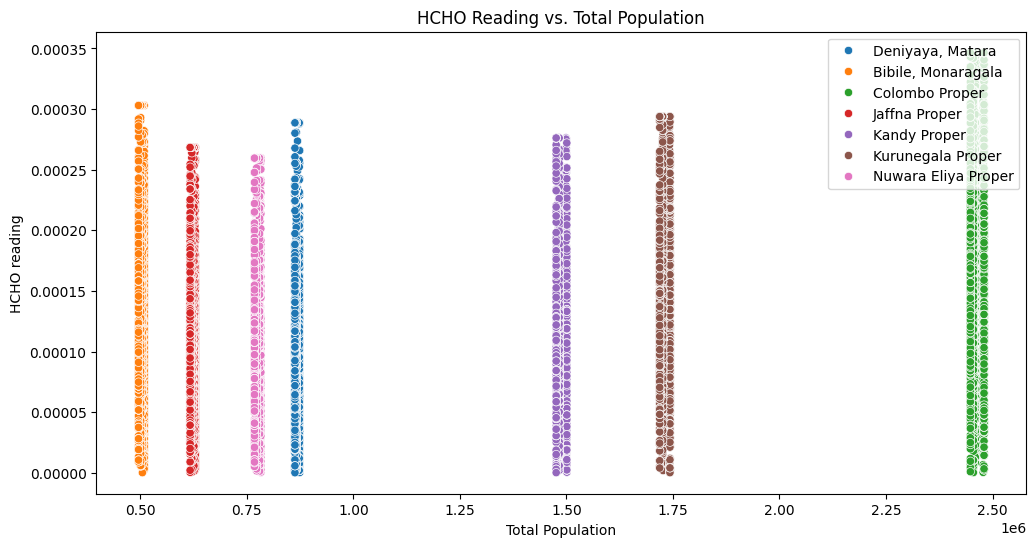

In [72]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Total Population', y='HCHO reading', hue='Location', data=population_joined_df.toPandas())
plt.title('HCHO Reading vs. Total Population')
plt.legend(loc='upper right')
plt.show()


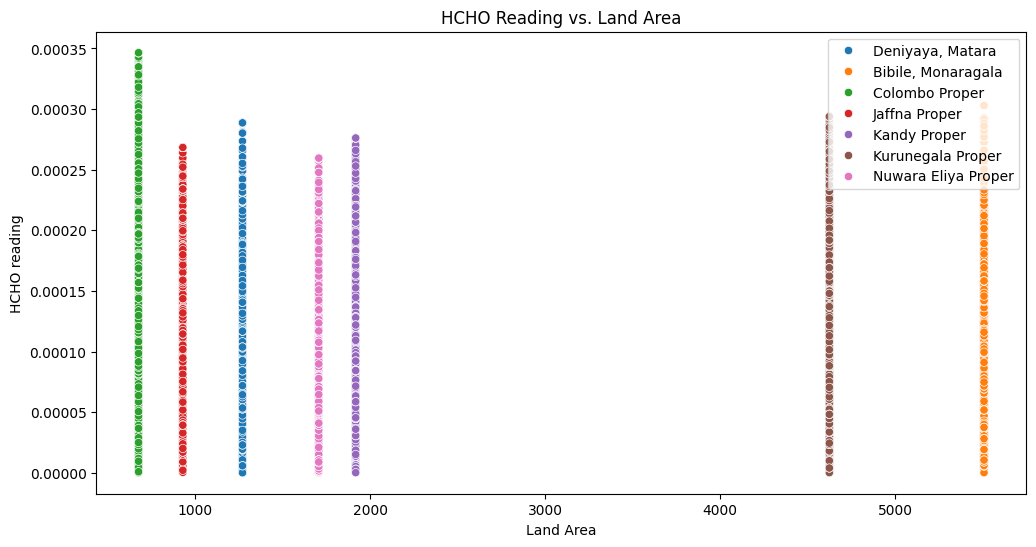

In [73]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Land Area', y='HCHO reading', hue='Location', data=population_joined_df.toPandas())
plt.title('HCHO Reading vs. Land Area')
plt.legend(loc='upper right')
plt.show()

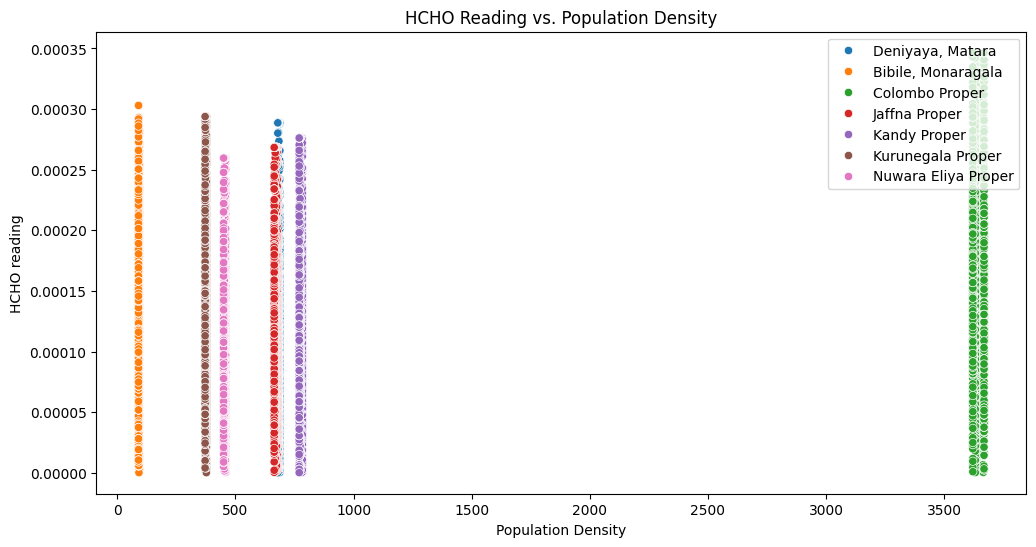

In [75]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Population Density', y='HCHO reading', hue='Location', data=population_joined_df.toPandas())
plt.title('HCHO Reading vs. Population Density')
plt.legend(loc='upper right')
plt.show()

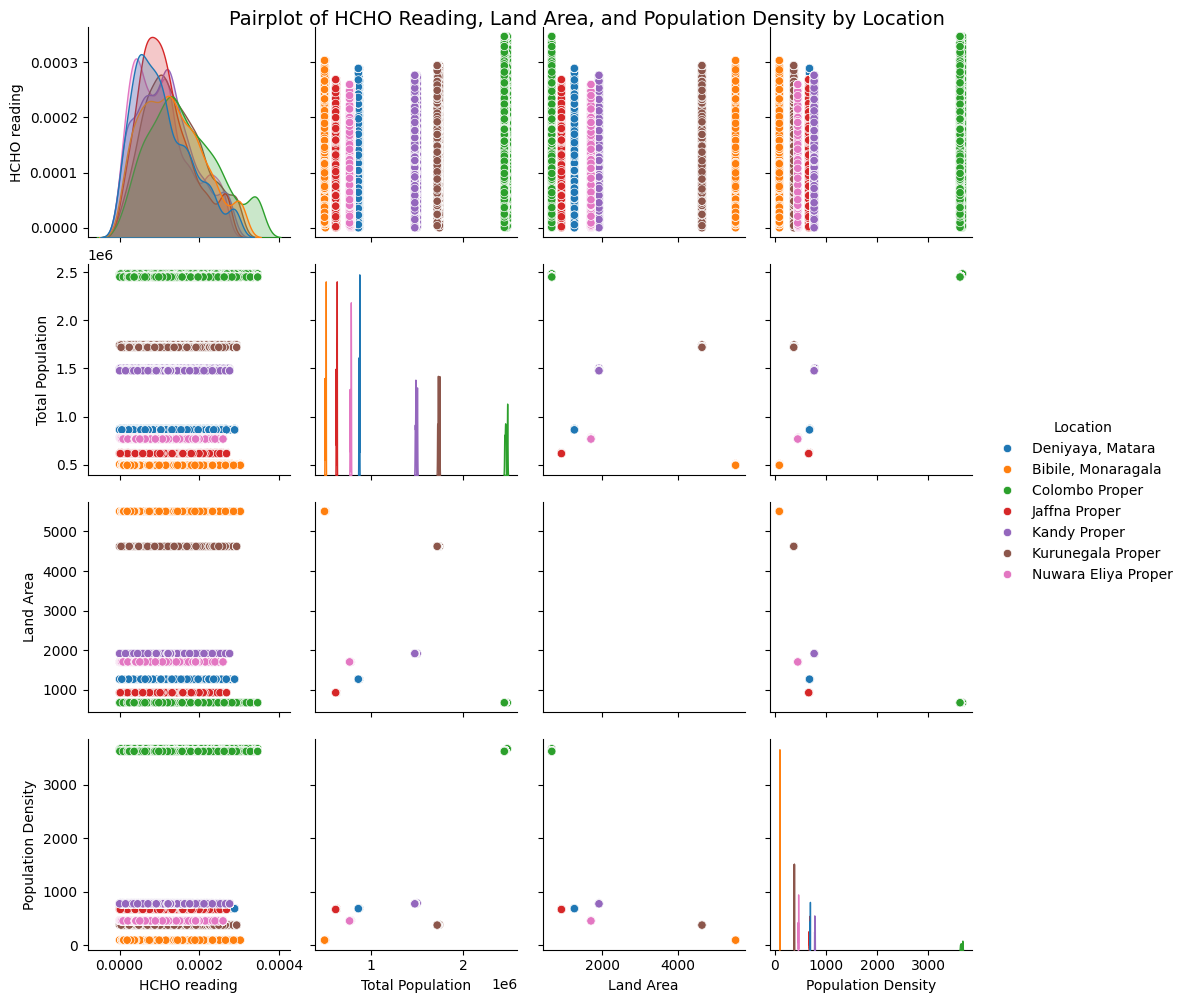

In [92]:
sns.pairplot(population_joined_df.toPandas(), vars=['HCHO reading', 'Total Population', 'Land Area', 'Population Density'], hue='Location')
plt.suptitle('Pairplot of HCHO Reading, Land Area, and Population Density by Location', fontsize=14, y=1)
plt.show()
